In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground"
z_diff = 0.2


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

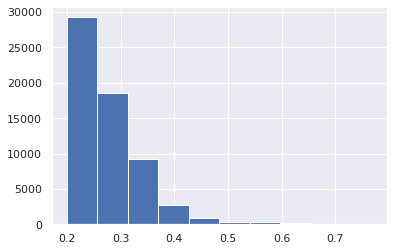

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

61554

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

5it [00:00, 47.51it/s]

15it [00:00, 56.10it/s]

26it [00:00, 64.64it/s]

35it [00:00, 67.68it/s]

44it [00:00, 70.40it/s]

54it [00:00, 75.89it/s]

64it [00:00, 81.73it/s]

73it [00:00, 83.95it/s]

83it [00:00, 86.92it/s]

92it [00:01, 87.46it/s]

101it [00:01, 82.66it/s]

111it [00:01, 85.27it/s]

121it [00:01, 88.26it/s]

131it [00:01, 90.82it/s]

141it [00:01, 90.51it/s]

151it [00:01, 84.18it/s]

161it [00:01, 87.69it/s]

170it [00:01, 82.86it/s]

179it [00:02, 80.86it/s]

188it [00:02, 79.05it/s]

198it [00:02, 84.07it/s]

208it [00:02, 88.21it/s]

218it [00:02, 90.30it/s]

228it [00:02, 91.67it/s]

238it [00:02, 88.61it/s]

248it [00:02, 91.60it/s]

258it [00:02, 87.93it/s]

267it [00:03, 81.29it/s]

276it [00:03, 82.32it/s]

286it [00:03, 84.29it/s]

295it [00:03, 84.20it/s]

305it [00:03, 87.36it/s]

315it [00:03, 88.88it/s]

325it [00:03, 90.83it/s]

335it [00:03, 91.36it/s]

345it [00:04, 83.15it/s]

354it [00:04, 85.02it/s]

364it [00:04, 88.51it/s]

374it [00:04, 90.81it/s]

384it [00:04, 92.90it/s]

394it [00:04, 94.83it/s]

404it [00:04, 95.14it/s]

414it [00:04, 94.98it/s]

425it [00:04, 97.33it/s]

436it [00:04, 98.35it/s]

446it [00:05, 98.16it/s]

456it [00:05, 98.45it/s]

467it [00:05, 99.15it/s]

477it [00:05, 98.15it/s]

487it [00:05, 97.97it/s]

497it [00:05, 98.53it/s]

507it [00:05, 98.33it/s]

517it [00:05, 98.07it/s]

527it [00:05, 98.32it/s]

537it [00:05, 98.26it/s]

547it [00:06, 97.81it/s]

557it [00:06, 97.07it/s]

567it [00:06, 97.86it/s]

577it [00:06, 97.58it/s]

588it [00:06, 98.75it/s]

599it [00:06, 98.78it/s]

609it [00:06, 98.86it/s]

620it [00:06, 99.10it/s]

630it [00:06, 99.33it/s]

640it [00:07, 98.42it/s]

650it [00:07, 98.80it/s]

660it [00:07, 98.40it/s]

670it [00:07, 98.38it/s]

680it [00:07, 97.89it/s]

691it [00:07, 98.50it/s]

702it [00:07, 99.68it/s]

713it [00:07, 100.35it/s]

724it [00:07, 100.04it/s]

735it [00:07, 99.86it/s] 

745it [00:08, 99.39it/s]

755it [00:08, 98.95it/s]

765it [00:08, 98.71it/s]

775it [00:08, 97.81it/s]

785it [00:08, 96.25it/s]

795it [00:08, 86.82it/s]

804it [00:08, 83.45it/s]

813it [00:08, 80.62it/s]

822it [00:08, 79.07it/s]

831it [00:09, 76.78it/s]

839it [00:09, 76.18it/s]

847it [00:09, 75.28it/s]

855it [00:09, 74.82it/s]

863it [00:09, 74.93it/s]

871it [00:09, 75.17it/s]

879it [00:09, 75.49it/s]

887it [00:09, 74.79it/s]

895it [00:09, 74.43it/s]

904it [00:10, 77.83it/s]

914it [00:10, 83.26it/s]

923it [00:10, 81.75it/s]

933it [00:10, 85.43it/s]

944it [00:10, 89.43it/s]

954it [00:10, 91.06it/s]

965it [00:10, 93.76it/s]

975it [00:10, 94.04it/s]

985it [00:10, 95.65it/s]

996it [00:11, 97.07it/s]

1006it [00:11, 96.19it/s]

1016it [00:11, 96.62it/s]

1026it [00:11, 91.59it/s]

1036it [00:11, 93.79it/s]

1046it [00:11, 94.44it/s]

1056it [00:11, 95.62it/s]

1066it [00:11, 95.84it/s]

1076it [00:11, 93.27it/s]

1086it [00:11, 94.47it/s]

1096it [00:12, 95.15it/s]

1106it [00:12, 96.36it/s]

1116it [00:12, 96.53it/s]

1126it [00:12, 95.66it/s]

1136it [00:12, 96.76it/s]

1146it [00:12, 89.88it/s]

1156it [00:12, 83.81it/s]

1166it [00:12, 86.68it/s]

1176it [00:12, 89.13it/s]

1186it [00:13, 91.75it/s]

1196it [00:13, 93.95it/s]

1206it [00:13, 94.58it/s]

1216it [00:13, 95.42it/s]

1226it [00:13, 95.41it/s]

1236it [00:13, 96.14it/s]

1246it [00:13, 96.15it/s]

1256it [00:13, 97.04it/s]

1266it [00:13, 96.72it/s]

1276it [00:14, 97.52it/s]

1286it [00:14, 86.53it/s]

1295it [00:14, 80.41it/s]

1305it [00:14, 85.06it/s]

1315it [00:14, 87.80it/s]

1325it [00:14, 89.04it/s]

1335it [00:14, 90.59it/s]

1345it [00:14, 91.09it/s]

1355it [00:14, 92.75it/s]

1365it [00:15, 92.97it/s]

1375it [00:15, 93.40it/s]

1385it [00:15, 89.77it/s]

1395it [00:15, 90.93it/s]

1405it [00:15, 92.04it/s]

1415it [00:15, 93.39it/s]

1425it [00:15, 94.28it/s]

1435it [00:15, 92.80it/s]

1445it [00:15, 93.90it/s]

1455it [00:15, 94.77it/s]

1465it [00:16, 94.51it/s]

1475it [00:16, 94.44it/s]

1485it [00:16, 94.23it/s]

1495it [00:16, 94.75it/s]

1505it [00:16, 94.99it/s]

1515it [00:16, 95.18it/s]

1525it [00:16, 94.09it/s]

1535it [00:16, 93.58it/s]

1545it [00:16, 92.43it/s]

1555it [00:17, 92.70it/s]

1565it [00:17, 94.59it/s]

1575it [00:17, 94.95it/s]

1585it [00:17, 95.51it/s]

1595it [00:17, 95.66it/s]

1605it [00:17, 95.47it/s]

1615it [00:17, 90.09it/s]

1625it [00:17, 90.42it/s]

1635it [00:17, 92.67it/s]

1645it [00:18, 94.32it/s]

1655it [00:18, 92.09it/s]

1665it [00:18, 90.34it/s]

1675it [00:18, 92.63it/s]

1685it [00:18, 93.89it/s]

1695it [00:18, 93.65it/s]

1705it [00:18, 94.19it/s]

1715it [00:18, 94.12it/s]

1725it [00:18, 95.59it/s]

1735it [00:18, 96.56it/s]

1745it [00:19, 96.18it/s]

1755it [00:19, 95.19it/s]

1765it [00:19, 95.57it/s]

1775it [00:19, 95.65it/s]

1785it [00:19, 94.96it/s]

1795it [00:19, 94.71it/s]

1805it [00:19, 93.85it/s]

1815it [00:19, 95.32it/s]

1825it [00:19, 86.93it/s]

1834it [00:20, 80.53it/s]

1843it [00:20, 77.75it/s]

1851it [00:20, 76.75it/s]

1860it [00:20, 79.54it/s]

1870it [00:20, 83.72it/s]

1879it [00:20, 74.90it/s]

1887it [00:20, 75.68it/s]

1897it [00:20, 80.10it/s]

1907it [00:20, 84.17it/s]

1917it [00:21, 86.06it/s]

1927it [00:21, 88.39it/s]

1937it [00:21, 89.67it/s]

1947it [00:21, 92.47it/s]

1957it [00:21, 93.28it/s]

1967it [00:21, 92.48it/s]

1977it [00:21, 92.87it/s]

1987it [00:21, 93.86it/s]

1997it [00:21, 94.71it/s]

2007it [00:22, 93.62it/s]

2017it [00:22, 94.07it/s]

2027it [00:22, 93.61it/s]

2037it [00:22, 94.00it/s]

2047it [00:22, 94.41it/s]

2057it [00:22, 95.27it/s]

2067it [00:22, 94.35it/s]

2077it [00:22, 95.00it/s]

2087it [00:22, 94.81it/s]

2097it [00:22, 95.18it/s]

2107it [00:23, 95.71it/s]

2117it [00:23, 95.37it/s]

2127it [00:23, 87.90it/s]

2136it [00:23, 84.28it/s]

2145it [00:23, 80.65it/s]

2154it [00:23, 76.33it/s]

2162it [00:23, 76.45it/s]

2171it [00:23, 80.05it/s]

2181it [00:24, 83.70it/s]

2190it [00:24, 81.46it/s]

2199it [00:24, 79.26it/s]

2208it [00:24, 76.93it/s]

2216it [00:24, 76.06it/s]

2224it [00:24, 75.22it/s]

2232it [00:24, 75.98it/s]

2242it [00:24, 81.18it/s]

2252it [00:24, 85.08it/s]

2262it [00:25, 88.63it/s]

2272it [00:25, 90.76it/s]

2282it [00:25, 91.91it/s]

2292it [00:25, 89.75it/s]

2302it [00:25, 92.17it/s]

2312it [00:25, 93.00it/s]

2322it [00:25, 94.20it/s]

2332it [00:25, 95.58it/s]

2342it [00:25, 95.97it/s]

2352it [00:25, 96.51it/s]

2362it [00:26, 96.59it/s]

2372it [00:26, 96.66it/s]

2382it [00:26, 96.87it/s]

2392it [00:26, 96.64it/s]

2402it [00:26, 97.59it/s]

2412it [00:26, 98.19it/s]

2422it [00:26, 98.57it/s]

2432it [00:26, 97.27it/s]

2442it [00:26, 97.66it/s]

2452it [00:26, 98.05it/s]

2462it [00:27, 97.90it/s]

2472it [00:27, 97.30it/s]

2482it [00:27, 97.16it/s]

2492it [00:27, 97.07it/s]

2502it [00:27, 96.59it/s]

2512it [00:27, 96.22it/s]

2522it [00:27, 96.29it/s]

2532it [00:27, 96.51it/s]

2542it [00:27, 93.87it/s]

2552it [00:28, 84.11it/s]

2561it [00:28, 81.44it/s]

2570it [00:28, 78.47it/s]

2578it [00:28, 76.52it/s]

2586it [00:28, 75.57it/s]

2594it [00:28, 74.25it/s]

2602it [00:28, 72.96it/s]

2611it [00:28, 76.81it/s]

2621it [00:28, 82.44it/s]

2631it [00:29, 85.75it/s]

2640it [00:29, 82.59it/s]

2650it [00:29, 86.07it/s]

2660it [00:29, 89.02it/s]

2670it [00:29, 90.46it/s]

2680it [00:29, 82.27it/s]

2690it [00:29, 85.97it/s]

2700it [00:29, 88.73it/s]

2711it [00:29, 91.94it/s]

2721it [00:30, 94.01it/s]

2732it [00:30, 95.99it/s]

2742it [00:30, 96.64it/s]

2752it [00:30, 96.14it/s]

2762it [00:30, 94.86it/s]

2772it [00:30, 95.13it/s]

2782it [00:30, 96.12it/s]

2792it [00:30, 96.73it/s]

2803it [00:30, 98.02it/s]

2813it [00:31, 95.68it/s]

2823it [00:31, 94.64it/s]

2833it [00:31, 95.25it/s]

2843it [00:31, 93.64it/s]

2853it [00:31, 92.35it/s]

2863it [00:31, 93.13it/s]

2873it [00:31, 94.98it/s]

2884it [00:31, 97.08it/s]

2894it [00:31, 97.88it/s]

2904it [00:31, 97.13it/s]

2914it [00:32, 97.16it/s]

2924it [00:32, 90.91it/s]

2934it [00:32, 91.91it/s]

2944it [00:32, 90.02it/s]

2954it [00:32, 83.63it/s]

2963it [00:32, 75.77it/s]

2973it [00:32, 80.61it/s]

2984it [00:32, 85.67it/s]

2994it [00:33, 87.97it/s]

3004it [00:33, 89.69it/s]

3014it [00:33, 91.47it/s]

3024it [00:33, 93.62it/s]

3034it [00:33, 94.36it/s]

3045it [00:33, 96.11it/s]

3055it [00:33, 94.42it/s]

3065it [00:33, 94.26it/s]

3075it [00:33, 95.80it/s]

3086it [00:33, 96.93it/s]

3096it [00:34, 96.85it/s]

3106it [00:34, 96.42it/s]

3116it [00:34, 96.17it/s]

3126it [00:34, 95.80it/s]

3136it [00:34, 96.24it/s]

3146it [00:34, 96.72it/s]

3156it [00:34, 96.34it/s]

3166it [00:34, 95.63it/s]

3176it [00:34, 95.94it/s]

3186it [00:35, 95.91it/s]

3196it [00:35, 96.24it/s]

3206it [00:35, 96.58it/s]

3216it [00:35, 96.56it/s]

3226it [00:35, 96.69it/s]

3236it [00:35, 97.12it/s]

3246it [00:35, 97.36it/s]

3256it [00:35, 96.63it/s]

3267it [00:35, 97.94it/s]

3277it [00:35, 97.33it/s]

3287it [00:36, 96.68it/s]

3297it [00:36, 96.53it/s]

3307it [00:36, 96.95it/s]

3317it [00:36, 97.40it/s]

3327it [00:36, 97.53it/s]

3337it [00:36, 97.76it/s]

3347it [00:36, 91.75it/s]

3357it [00:36, 92.61it/s]

3367it [00:36, 94.14it/s]

3377it [00:37, 95.16it/s]

3387it [00:37, 96.03it/s]

3397it [00:37, 96.90it/s]

3407it [00:37, 97.20it/s]

3418it [00:37, 98.53it/s]

3429it [00:37, 99.04it/s]

3439it [00:37, 98.23it/s]

3449it [00:37, 96.42it/s]

3459it [00:37, 97.00it/s]

3469it [00:37, 97.53it/s]

3480it [00:38, 98.60it/s]

3490it [00:38, 97.69it/s]

3500it [00:38, 97.20it/s]

3510it [00:38, 97.07it/s]

3520it [00:38, 97.06it/s]

3530it [00:38, 97.28it/s]

3540it [00:38, 97.01it/s]

3550it [00:38, 97.77it/s]

3560it [00:38, 97.23it/s]

3570it [00:38, 96.61it/s]

3580it [00:39, 85.67it/s]

3589it [00:39, 83.21it/s]

3598it [00:39, 81.52it/s]

3607it [00:39, 78.63it/s]

3615it [00:39, 78.01it/s]

3623it [00:39, 76.62it/s]

3631it [00:39, 75.20it/s]

3639it [00:39, 75.50it/s]

3647it [00:40, 74.67it/s]

3655it [00:40, 74.55it/s]

3665it [00:40, 79.33it/s]

3674it [00:40, 81.01it/s]

3684it [00:40, 83.93it/s]

3694it [00:40, 87.99it/s]

3704it [00:40, 89.25it/s]

3714it [00:40, 91.99it/s]

3725it [00:40, 94.54it/s]

3735it [00:40, 94.06it/s]

3745it [00:41, 95.70it/s]

3755it [00:41, 96.24it/s]

3765it [00:41, 96.62it/s]

3775it [00:41, 96.53it/s]

3785it [00:41, 97.33it/s]

3795it [00:41, 96.08it/s]

3806it [00:41, 97.30it/s]

3816it [00:41, 97.59it/s]

3826it [00:41, 97.78it/s]

3836it [00:42, 97.74it/s]

3846it [00:42, 97.39it/s]

3856it [00:42, 97.22it/s]

3867it [00:42, 98.43it/s]

3877it [00:42, 96.73it/s]

3887it [00:42, 97.60it/s]

3898it [00:42, 99.48it/s]

3908it [00:42, 98.91it/s]

3918it [00:42, 97.74it/s]

3928it [00:42, 98.31it/s]

3938it [00:43, 96.76it/s]

3948it [00:43, 96.52it/s]

3958it [00:43, 96.36it/s]

3968it [00:43, 95.86it/s]

3978it [00:43, 93.21it/s]

3988it [00:43, 86.65it/s]

3997it [00:43, 81.63it/s]

4006it [00:43, 78.48it/s]

4016it [00:43, 82.55it/s]

4026it [00:44, 85.64it/s]

4035it [00:44, 86.69it/s]

4044it [00:44, 84.08it/s]

4054it [00:44, 86.80it/s]

4064it [00:44, 89.08it/s]

4074it [00:44, 91.14it/s]

4085it [00:44, 94.04it/s]

4096it [00:44, 95.85it/s]

4106it [00:44, 96.56it/s]

4116it [00:45, 95.93it/s]

4126it [00:45, 95.82it/s]

4136it [00:45, 97.01it/s]

4146it [00:45, 97.35it/s]

4156it [00:45, 95.81it/s]

4167it [00:45, 97.33it/s]

4177it [00:45, 94.13it/s]

4187it [00:45, 92.52it/s]

4197it [00:45, 87.36it/s]

4207it [00:46, 90.55it/s]

4217it [00:46, 92.84it/s]

4228it [00:46, 95.23it/s]

4238it [00:46, 93.99it/s]

4248it [00:46, 88.99it/s]

4257it [00:46, 86.07it/s]

4267it [00:46, 87.99it/s]

4277it [00:46, 90.33it/s]

4287it [00:46, 91.85it/s]

4297it [00:47, 93.33it/s]

4307it [00:47, 94.63it/s]

4318it [00:47, 96.24it/s]

4328it [00:47, 96.72it/s]

4338it [00:47, 97.59it/s]

4348it [00:47, 92.26it/s]

4358it [00:47, 93.96it/s]

4368it [00:47, 94.10it/s]

4378it [00:47, 93.59it/s]

4388it [00:47, 95.28it/s]

4398it [00:48, 96.12it/s]

4408it [00:48, 96.22it/s]

4418it [00:48, 92.38it/s]

4428it [00:48, 93.57it/s]

4438it [00:48, 94.49it/s]

4448it [00:48, 94.99it/s]

4458it [00:48, 94.96it/s]

4468it [00:48, 95.93it/s]

4478it [00:48, 95.99it/s]

4488it [00:49, 95.56it/s]

4498it [00:49, 95.78it/s]

4508it [00:49, 95.40it/s]

4518it [00:49, 96.46it/s]

4528it [00:49, 96.24it/s]

4538it [00:49, 95.63it/s]

4548it [00:49, 95.11it/s]

4558it [00:49, 95.24it/s]

4568it [00:49, 95.22it/s]

4578it [00:49, 96.20it/s]

4588it [00:50, 95.99it/s]

4598it [00:50, 95.76it/s]

4608it [00:50, 89.01it/s]

4617it [00:50, 84.67it/s]

4626it [00:50, 81.47it/s]

4635it [00:50, 78.43it/s]

4643it [00:50, 76.06it/s]

4653it [00:50, 80.63it/s]

4663it [00:50, 84.31it/s]

4673it [00:51, 87.10it/s]

4683it [00:51, 90.52it/s]

4693it [00:51, 92.26it/s]

4703it [00:51, 92.75it/s]

4713it [00:51, 93.17it/s]

4723it [00:51, 93.88it/s]

4733it [00:51, 93.31it/s]

4743it [00:51, 92.36it/s]

4753it [00:51, 83.23it/s]

4762it [00:52, 84.49it/s]

4772it [00:52, 86.82it/s]

4782it [00:52, 88.48it/s]

4792it [00:52, 89.01it/s]

4802it [00:52, 91.59it/s]

4812it [00:52, 92.13it/s]

4822it [00:52, 92.88it/s]

4832it [00:52, 92.67it/s]

4842it [00:52, 93.78it/s]

4852it [00:53, 92.42it/s]

4862it [00:53, 92.37it/s]

4872it [00:53, 86.14it/s]

4881it [00:53, 86.72it/s]

4891it [00:53, 88.69it/s]

4901it [00:53, 90.99it/s]

4911it [00:53, 93.29it/s]

4921it [00:53, 91.03it/s]

4931it [00:53, 75.25it/s]

4940it [00:54, 70.22it/s]

4949it [00:54, 74.11it/s]

4959it [00:54, 79.04it/s]

4968it [00:54, 78.98it/s]

4978it [00:54, 83.18it/s]

4989it [00:54, 87.79it/s]

4999it [00:54, 90.37it/s]

5009it [00:54, 91.54it/s]

5019it [00:55, 92.96it/s]

5029it [00:55, 93.91it/s]

5039it [00:55, 94.86it/s]

5049it [00:55, 84.52it/s]

5058it [00:55, 80.52it/s]

5067it [00:55, 77.80it/s]

5075it [00:55, 75.71it/s]

5083it [00:55, 70.12it/s]

5091it [00:55, 70.71it/s]

5099it [00:56, 71.78it/s]

5107it [00:56, 70.47it/s]

5115it [00:56, 71.04it/s]

5123it [00:56, 72.63it/s]

5131it [00:56, 72.54it/s]

5139it [00:56, 72.23it/s]

5147it [00:56, 72.79it/s]

5155it [00:56, 74.15it/s]

5165it [00:56, 79.39it/s]

5174it [00:57, 82.15it/s]

5184it [00:57, 85.04it/s]

5194it [00:57, 86.60it/s]

5204it [00:57, 88.82it/s]

5213it [00:57, 88.88it/s]

5223it [00:57, 89.71it/s]

5233it [00:57, 85.44it/s]

5243it [00:57, 87.61it/s]

5253it [00:57, 89.43it/s]

5263it [00:58, 91.70it/s]

5273it [00:58, 92.48it/s]

5283it [00:58, 92.49it/s]

5293it [00:58, 93.83it/s]

5303it [00:58, 93.77it/s]

5313it [00:58, 92.69it/s]

5323it [00:58, 92.70it/s]

5333it [00:58, 93.35it/s]

5343it [00:58, 93.34it/s]

5353it [00:58, 93.80it/s]

5363it [00:59, 92.37it/s]

5373it [00:59, 89.10it/s]

5384it [00:59, 92.21it/s]

5394it [00:59, 93.66it/s]

5404it [00:59, 94.26it/s]

5414it [00:59, 95.48it/s]

5424it [00:59, 95.19it/s]

5434it [00:59, 95.73it/s]

5444it [00:59, 96.45it/s]

5454it [01:00, 97.10it/s]

5464it [01:00, 97.74it/s]

5474it [01:00, 94.16it/s]

5484it [01:00, 88.95it/s]

5493it [01:00, 86.66it/s]

5503it [01:00, 88.94it/s]

5512it [01:00, 87.02it/s]

5521it [01:00, 82.97it/s]

5531it [01:00, 86.19it/s]

5541it [01:01, 88.34it/s]

5550it [01:01, 85.67it/s]

5559it [01:01, 84.36it/s]

5568it [01:01, 80.23it/s]

5577it [01:01, 76.91it/s]

5585it [01:01, 76.81it/s]

5595it [01:01, 81.98it/s]

5605it [01:01, 85.06it/s]

5614it [01:01, 79.12it/s]

5623it [01:02, 78.19it/s]

5633it [01:02, 82.67it/s]

5643it [01:02, 86.34it/s]

5653it [01:02, 89.35it/s]

5663it [01:02, 90.95it/s]

5673it [01:02, 92.30it/s]

5683it [01:02, 93.20it/s]

5693it [01:02, 92.43it/s]

5703it [01:02, 89.14it/s]

5713it [01:03, 90.03it/s]

5723it [01:03, 91.77it/s]

5733it [01:03, 91.59it/s]

5743it [01:03, 91.82it/s]

5753it [01:03, 92.55it/s]

5763it [01:03, 91.97it/s]

5773it [01:03, 91.77it/s]

5783it [01:03, 92.12it/s]

5793it [01:03, 91.90it/s]

5803it [01:04, 91.34it/s]

5813it [01:04, 91.96it/s]

5823it [01:04, 92.13it/s]

5833it [01:04, 91.99it/s]

5843it [01:04, 93.00it/s]

5853it [01:04, 91.97it/s]

5863it [01:04, 92.64it/s]

5873it [01:04, 93.03it/s]

5883it [01:04, 93.22it/s]

5893it [01:04, 93.44it/s]

5903it [01:05, 93.12it/s]

5913it [01:05, 88.69it/s]

5922it [01:05, 88.47it/s]

5931it [01:05, 83.47it/s]

5940it [01:05, 79.27it/s]

5949it [01:05, 76.46it/s]

5957it [01:05, 74.84it/s]

5965it [01:05, 74.03it/s]

5973it [01:06, 72.96it/s]

5981it [01:06, 74.02it/s]

5989it [01:06, 73.59it/s]

5997it [01:06, 75.28it/s]

6005it [01:06, 72.03it/s]

6014it [01:06, 75.83it/s]

6024it [01:06, 80.05it/s]

6034it [01:06, 84.36it/s]

6044it [01:06, 87.00it/s]

6054it [01:07, 89.09it/s]

6064it [01:07, 90.27it/s]

6074it [01:07, 91.85it/s]

6084it [01:07, 93.09it/s]

6094it [01:07, 93.99it/s]

6104it [01:07, 90.13it/s]

6114it [01:07, 92.10it/s]

6124it [01:07, 92.96it/s]

6134it [01:07, 92.80it/s]

6144it [01:07, 93.28it/s]

6154it [01:08, 93.76it/s]

6164it [01:08, 92.76it/s]

6174it [01:08, 92.92it/s]

6184it [01:08, 92.97it/s]

6194it [01:08, 93.08it/s]

6204it [01:08, 93.45it/s]

6214it [01:08, 94.06it/s]

6224it [01:08, 94.08it/s]

6234it [01:08, 93.29it/s]

6244it [01:09, 77.11it/s]

6253it [01:09, 72.59it/s]

6263it [01:09, 77.25it/s]

6273it [01:09, 81.01it/s]

6283it [01:09, 83.64it/s]

6293it [01:09, 86.18it/s]

6303it [01:09, 88.08it/s]

6313it [01:09, 89.87it/s]

6323it [01:10, 90.51it/s]

6333it [01:10, 92.04it/s]

6343it [01:10, 86.22it/s]

6353it [01:10, 87.70it/s]

6363it [01:10, 89.37it/s]

6373it [01:10, 90.57it/s]

6383it [01:10, 91.43it/s]

6393it [01:10, 90.85it/s]

6403it [01:10, 88.53it/s]

6413it [01:11, 89.99it/s]

6423it [01:11, 91.10it/s]

6433it [01:11, 91.14it/s]

6443it [01:11, 92.43it/s]

6453it [01:11, 92.65it/s]

6463it [01:11, 92.54it/s]

6473it [01:11, 91.79it/s]

6483it [01:11, 86.89it/s]

6493it [01:11, 89.03it/s]

6503it [01:12, 90.74it/s]

6513it [01:12, 91.26it/s]

6523it [01:12, 91.63it/s]

6533it [01:12, 92.40it/s]

6543it [01:12, 93.35it/s]

6553it [01:12, 93.37it/s]

6563it [01:12, 89.96it/s]

6573it [01:12, 91.32it/s]

6583it [01:12, 93.51it/s]

6593it [01:12, 93.85it/s]

6603it [01:13, 93.99it/s]

6613it [01:13, 94.51it/s]

6623it [01:13, 95.11it/s]

6633it [01:13, 95.45it/s]

6643it [01:13, 95.85it/s]

6653it [01:13, 95.20it/s]

6663it [01:13, 95.34it/s]

6673it [01:13, 94.67it/s]

6684it [01:13, 96.38it/s]

6694it [01:14, 90.01it/s]

6704it [01:14, 87.30it/s]

6713it [01:14, 80.80it/s]

6722it [01:14, 74.40it/s]

6730it [01:14, 73.78it/s]

6738it [01:14, 73.56it/s]

6746it [01:14, 73.64it/s]

6755it [01:14, 77.82it/s]

6764it [01:14, 80.24it/s]

6774it [01:15, 83.56it/s]

6783it [01:15, 81.67it/s]

6793it [01:15, 84.00it/s]

6803it [01:15, 86.18it/s]

6812it [01:15, 86.49it/s]

6822it [01:15, 87.60it/s]

6832it [01:15, 89.62it/s]

6842it [01:15, 90.35it/s]

6852it [01:15, 90.81it/s]

6862it [01:16, 90.50it/s]

6872it [01:16, 90.35it/s]

6882it [01:16, 90.64it/s]

6892it [01:16, 90.48it/s]

6902it [01:16, 90.72it/s]

6912it [01:16, 91.01it/s]

6922it [01:16, 90.87it/s]

6932it [01:16, 90.53it/s]

6942it [01:16, 89.88it/s]

6952it [01:17, 90.83it/s]

6962it [01:17, 91.46it/s]

6972it [01:17, 88.26it/s]

6982it [01:17, 88.98it/s]

6992it [01:17, 90.69it/s]

7002it [01:17, 89.47it/s]

7012it [01:17, 91.49it/s]

7022it [01:17, 80.32it/s]

7032it [01:18, 83.23it/s]

7042it [01:18, 86.00it/s]

7051it [01:18, 86.43it/s]

7060it [01:18, 85.22it/s]

7069it [01:18, 77.79it/s]

7077it [01:18, 75.38it/s]

7086it [01:18, 77.10it/s]

7094it [01:18, 76.38it/s]

7102it [01:18, 75.61it/s]

7110it [01:19, 74.45it/s]

7118it [01:19, 72.54it/s]

7127it [01:19, 76.96it/s]

7137it [01:19, 80.76it/s]

7147it [01:19, 83.44it/s]

7156it [01:19, 84.63it/s]

7166it [01:19, 86.69it/s]

7176it [01:19, 88.98it/s]

7186it [01:19, 90.59it/s]

7196it [01:19, 90.43it/s]

7206it [01:20, 92.18it/s]

7216it [01:20, 91.69it/s]

7226it [01:20, 86.60it/s]

7235it [01:20, 80.04it/s]

7244it [01:20, 82.34it/s]

7254it [01:20, 85.24it/s]

7263it [01:20, 85.75it/s]

7273it [01:20, 87.52it/s]

7283it [01:20, 89.03it/s]

7293it [01:21, 90.19it/s]

7303it [01:21, 91.16it/s]

7313it [01:21, 92.86it/s]

7323it [01:21, 94.01it/s]

7333it [01:21, 91.00it/s]

7343it [01:21, 89.40it/s]

7353it [01:21, 90.34it/s]

7363it [01:21, 91.32it/s]

7373it [01:21, 91.47it/s]

7383it [01:22, 91.04it/s]

7393it [01:22, 91.08it/s]

7403it [01:22, 92.19it/s]

7413it [01:22, 86.84it/s]

7423it [01:22, 88.21it/s]

7432it [01:22, 71.64it/s]

7440it [01:22, 71.13it/s]

7448it [01:22, 72.26it/s]

7456it [01:23, 66.83it/s]

7464it [01:23, 68.23it/s]

7472it [01:23, 69.18it/s]

7480it [01:23, 68.65it/s]

7488it [01:23, 70.15it/s]

7498it [01:23, 76.07it/s]

7507it [01:23, 78.62it/s]

7516it [01:23, 74.16it/s]

7524it [01:24, 72.36it/s]

7534it [01:24, 77.30it/s]

7542it [01:24, 76.13it/s]

7551it [01:24, 79.53it/s]

7560it [01:24, 78.84it/s]

7570it [01:24, 83.97it/s]

7580it [01:24, 87.11it/s]

7589it [01:24, 77.78it/s]

7598it [01:24, 78.66it/s]

7607it [01:25, 74.90it/s]

7615it [01:25, 73.68it/s]

7623it [01:25, 69.55it/s]

7631it [01:25, 68.65it/s]

7638it [01:25, 66.56it/s]

7648it [01:25, 73.04it/s]

7658it [01:25, 77.91it/s]

7668it [01:25, 81.71it/s]

7677it [01:25, 83.86it/s]

7687it [01:26, 85.87it/s]

7697it [01:26, 87.65it/s]

7707it [01:26, 89.76it/s]

7717it [01:26, 90.62it/s]

7727it [01:26, 80.89it/s]

7736it [01:26, 74.06it/s]

7744it [01:26, 66.69it/s]

7752it [01:26, 67.80it/s]

7760it [01:27, 68.29it/s]

7769it [01:27, 73.43it/s]

7779it [01:27, 78.12it/s]

7789it [01:27, 81.77it/s]

7798it [01:27, 80.79it/s]

7807it [01:27, 79.78it/s]

7816it [01:27, 81.17it/s]

7826it [01:27, 83.89it/s]

7836it [01:27, 85.89it/s]

7846it [01:28, 88.11it/s]

7856it [01:28, 89.05it/s]

7865it [01:28, 89.09it/s]

7874it [01:28, 89.34it/s]

7884it [01:28, 89.75it/s]

7894it [01:28, 90.12it/s]

7904it [01:28, 90.66it/s]

7914it [01:28, 90.37it/s]

7924it [01:28, 91.01it/s]

7934it [01:28, 91.77it/s]

7944it [01:29, 91.07it/s]

7954it [01:29, 92.29it/s]

7964it [01:29, 91.77it/s]

7974it [01:29, 80.15it/s]

7983it [01:29, 80.74it/s]

7992it [01:29, 79.48it/s]

8001it [01:29, 75.62it/s]

8011it [01:29, 79.80it/s]

8021it [01:30, 83.63it/s]

8031it [01:30, 87.07it/s]

8040it [01:30, 69.01it/s]

8048it [01:30, 68.79it/s]

8056it [01:30, 70.52it/s]

8066it [01:30, 75.38it/s]

8076it [01:30, 79.61it/s]

8086it [01:30, 83.07it/s]

8095it [01:31, 82.97it/s]

8105it [01:31, 86.35it/s]

8115it [01:31, 88.65it/s]

8125it [01:31, 90.20it/s]

8135it [01:31, 90.76it/s]

8145it [01:31, 91.46it/s]

8155it [01:31, 84.86it/s]

8164it [01:31, 80.11it/s]

8173it [01:31, 78.67it/s]

8181it [01:32, 70.21it/s]

8191it [01:32, 76.07it/s]

8201it [01:32, 80.07it/s]

8210it [01:32, 82.66it/s]

8219it [01:32, 84.70it/s]

8229it [01:32, 87.22it/s]

8238it [01:32, 86.20it/s]

8247it [01:32, 83.45it/s]

8257it [01:32, 86.47it/s]

8267it [01:33, 87.94it/s]

8277it [01:33, 89.10it/s]

8287it [01:33, 89.42it/s]

8296it [01:33, 86.21it/s]

8306it [01:33, 87.89it/s]

8315it [01:33, 86.31it/s]

8325it [01:33, 89.06it/s]

8334it [01:33, 88.92it/s]

8344it [01:33, 89.59it/s]

8354it [01:34, 89.76it/s]

8364it [01:34, 90.65it/s]

8374it [01:34, 90.07it/s]

8384it [01:34, 90.41it/s]

8394it [01:34, 91.12it/s]

8404it [01:34, 90.73it/s]

8414it [01:34, 91.54it/s]

8424it [01:34, 90.90it/s]

8434it [01:34, 91.39it/s]

8444it [01:34, 91.02it/s]

8454it [01:35, 89.78it/s]

8464it [01:35, 90.60it/s]

8474it [01:35, 91.43it/s]

8484it [01:35, 91.30it/s]

8494it [01:35, 92.30it/s]

8504it [01:35, 92.56it/s]

8514it [01:35, 92.79it/s]

8524it [01:35, 93.00it/s]

8534it [01:35, 92.39it/s]

8544it [01:36, 93.35it/s]

8554it [01:36, 92.48it/s]

8564it [01:36, 91.21it/s]

8574it [01:36, 91.49it/s]

8584it [01:36, 92.21it/s]

8594it [01:36, 93.04it/s]

8604it [01:36, 92.55it/s]

8614it [01:36, 91.98it/s]

8624it [01:36, 92.02it/s]

8634it [01:37, 83.34it/s]

8643it [01:37, 77.98it/s]

8651it [01:37, 74.61it/s]

8659it [01:37, 73.30it/s]

8667it [01:37, 72.39it/s]

8675it [01:37, 72.01it/s]

8683it [01:37, 68.00it/s]

8691it [01:37, 68.86it/s]

8698it [01:38, 69.09it/s]

8705it [01:38, 67.21it/s]

8713it [01:38, 68.51it/s]

8720it [01:38, 68.12it/s]

8727it [01:38, 68.25it/s]

8735it [01:38, 69.04it/s]

8743it [01:38, 69.67it/s]

8752it [01:38, 74.56it/s]

8762it [01:38, 79.39it/s]

8772it [01:39, 82.41it/s]

8782it [01:39, 84.48it/s]

8791it [01:39, 85.95it/s]

8800it [01:39, 84.30it/s]

8810it [01:39, 87.18it/s]

8819it [01:39, 87.95it/s]

8829it [01:39, 89.05it/s]

8838it [01:39, 88.02it/s]

8848it [01:39, 89.66it/s]

8858it [01:39, 90.47it/s]

8868it [01:40, 91.78it/s]

8878it [01:40, 90.72it/s]

8888it [01:40, 91.35it/s]

8898it [01:40, 91.69it/s]

8908it [01:40, 92.90it/s]

8918it [01:40, 93.28it/s]

8928it [01:40, 93.36it/s]

8938it [01:40, 83.86it/s]

8947it [01:40, 79.80it/s]

8956it [01:41, 76.13it/s]

8964it [01:41, 74.64it/s]

8972it [01:41, 73.14it/s]

8980it [01:41, 72.22it/s]

8988it [01:41, 70.39it/s]

8996it [01:41, 70.19it/s]

9004it [01:41, 70.73it/s]

9014it [01:41, 75.74it/s]

9024it [01:42, 77.40it/s]

9033it [01:42, 79.46it/s]

9043it [01:42, 82.77it/s]

9053it [01:42, 85.14it/s]

9062it [01:42, 86.25it/s]

9072it [01:42, 87.52it/s]

9081it [01:42, 88.06it/s]

9091it [01:42, 89.34it/s]

9101it [01:42, 89.61it/s]

9111it [01:43, 89.87it/s]

9121it [01:43, 90.10it/s]

9131it [01:43, 89.86it/s]

9141it [01:43, 90.65it/s]

9151it [01:43, 89.77it/s]

9160it [01:43, 89.74it/s]

9170it [01:43, 90.25it/s]

9180it [01:43, 90.69it/s]

9190it [01:43, 89.18it/s]

9199it [01:43, 87.58it/s]

9209it [01:44, 88.79it/s]

9219it [01:44, 89.90it/s]

9229it [01:44, 88.68it/s]

9239it [01:44, 90.06it/s]

9249it [01:44, 89.87it/s]

9258it [01:44, 89.43it/s]

9268it [01:44, 89.88it/s]

9278it [01:44, 91.32it/s]

9288it [01:44, 90.90it/s]

9298it [01:45, 90.03it/s]

9308it [01:45, 89.02it/s]

9317it [01:45, 88.53it/s]

9326it [01:45, 81.32it/s]

9335it [01:45, 77.34it/s]

9343it [01:45, 74.79it/s]

9351it [01:45, 71.62it/s]

9361it [01:45, 76.97it/s]

9370it [01:46, 80.34it/s]

9380it [01:46, 83.18it/s]

9390it [01:46, 85.57it/s]

9400it [01:46, 87.08it/s]

9409it [01:46, 86.67it/s]

9418it [01:46, 87.51it/s]

9428it [01:46, 88.20it/s]

9437it [01:46, 88.70it/s]

9446it [01:46, 88.84it/s]

9456it [01:46, 89.83it/s]

9465it [01:47, 86.63it/s]

9474it [01:47, 85.57it/s]

9484it [01:47, 87.12it/s]

9493it [01:47, 81.08it/s]

9503it [01:47, 83.59it/s]

9512it [01:47, 84.69it/s]

9522it [01:47, 86.91it/s]

9531it [01:47, 83.98it/s]

9540it [01:47, 78.12it/s]

9548it [01:48, 75.76it/s]

9556it [01:48, 73.49it/s]

9564it [01:48, 71.86it/s]

9573it [01:48, 75.17it/s]

9583it [01:48, 79.27it/s]

9593it [01:48, 82.63it/s]

9603it [01:48, 84.86it/s]

9613it [01:48, 87.81it/s]

9623it [01:48, 89.26it/s]

9633it [01:49, 90.47it/s]

9643it [01:49, 90.82it/s]

9653it [01:49, 90.98it/s]

9663it [01:49, 91.09it/s]

9673it [01:49, 90.60it/s]

9683it [01:49, 91.14it/s]

9693it [01:49, 91.32it/s]

9703it [01:49, 91.37it/s]

9713it [01:49, 92.05it/s]

9723it [01:50, 91.47it/s]

9733it [01:50, 90.58it/s]

9743it [01:50, 90.17it/s]

9753it [01:50, 90.37it/s]

9763it [01:50, 90.65it/s]

9773it [01:50, 90.71it/s]

9783it [01:50, 88.47it/s]

9793it [01:50, 89.29it/s]

9803it [01:50, 89.68it/s]

9813it [01:51, 90.68it/s]

9823it [01:51, 82.24it/s]

9832it [01:51, 81.94it/s]

9842it [01:51, 84.17it/s]

9852it [01:51, 86.08it/s]

9861it [01:51, 86.74it/s]

9870it [01:51, 87.45it/s]

9879it [01:51, 83.46it/s]

9888it [01:52, 78.99it/s]

9896it [01:52, 77.18it/s]

9906it [01:52, 81.31it/s]

9916it [01:52, 84.04it/s]

9926it [01:52, 86.20it/s]

9936it [01:52, 87.56it/s]

9945it [01:52, 81.48it/s]

9954it [01:52, 81.06it/s]

9963it [01:52, 81.43it/s]

9972it [01:53, 82.00it/s]

9982it [01:53, 84.88it/s]

9992it [01:53, 87.72it/s]

10002it [01:53, 89.06it/s]

10012it [01:53, 90.69it/s]

10022it [01:53, 91.30it/s]

10032it [01:53, 91.89it/s]

10042it [01:53, 91.76it/s]

10052it [01:53, 91.63it/s]

10062it [01:53, 91.76it/s]

10072it [01:54, 91.08it/s]

10082it [01:54, 91.31it/s]

10092it [01:54, 90.60it/s]

10102it [01:54, 90.37it/s]

10112it [01:54, 90.74it/s]

10122it [01:54, 90.85it/s]

10132it [01:54, 91.89it/s]

10142it [01:54, 92.50it/s]

10152it [01:54, 92.78it/s]

10162it [01:55, 93.90it/s]

10172it [01:55, 93.81it/s]

10182it [01:55, 94.47it/s]

10192it [01:55, 93.84it/s]

10202it [01:55, 93.69it/s]

10212it [01:55, 93.22it/s]

10222it [01:55, 93.02it/s]

10232it [01:55, 93.43it/s]

10242it [01:55, 92.30it/s]

10252it [01:56, 92.74it/s]

10262it [01:56, 91.85it/s]

10272it [01:56, 92.03it/s]

10282it [01:56, 92.88it/s]

10292it [01:56, 93.02it/s]

10302it [01:56, 92.83it/s]

10312it [01:56, 92.32it/s]

10322it [01:56, 92.30it/s]

10332it [01:56, 92.43it/s]

10342it [01:57, 92.64it/s]

10352it [01:57, 92.55it/s]

10362it [01:57, 92.28it/s]

10372it [01:57, 91.61it/s]

10382it [01:57, 91.94it/s]

10392it [01:57, 91.25it/s]

10402it [01:57, 89.39it/s]

10411it [01:57, 89.26it/s]

10420it [01:57, 89.38it/s]

10429it [01:57, 85.21it/s]

10438it [01:58, 86.34it/s]

10448it [01:58, 88.91it/s]

10458it [01:58, 89.92it/s]

10468it [01:58, 90.38it/s]

10478it [01:58, 90.54it/s]

10488it [01:58, 91.49it/s]

10498it [01:58, 91.27it/s]

10508it [01:58, 91.60it/s]

10518it [01:58, 91.60it/s]

10528it [01:59, 81.63it/s]

10537it [01:59, 77.10it/s]

10545it [01:59, 74.54it/s]

10553it [01:59, 73.32it/s]

10561it [01:59, 72.33it/s]

10569it [01:59, 69.16it/s]

10577it [01:59, 69.48it/s]

10585it [01:59, 71.09it/s]

10595it [02:00, 76.56it/s]

10605it [02:00, 80.23it/s]

10615it [02:00, 82.96it/s]

10624it [02:00, 84.21it/s]

10633it [02:00, 85.09it/s]

10643it [02:00, 87.58it/s]

10653it [02:00, 88.87it/s]

10663it [02:00, 90.40it/s]

10673it [02:00, 91.38it/s]

10683it [02:01, 92.04it/s]

10693it [02:01, 92.62it/s]

10703it [02:01, 93.71it/s]

10713it [02:01, 94.61it/s]

10723it [02:01, 94.87it/s]

10733it [02:01, 95.13it/s]

10743it [02:01, 83.40it/s]

10752it [02:01, 78.92it/s]

10761it [02:01, 76.78it/s]

10769it [02:02, 73.97it/s]

10777it [02:02, 72.75it/s]

10785it [02:02, 72.26it/s]

10793it [02:02, 70.79it/s]

10801it [02:02, 71.40it/s]

10809it [02:02, 71.62it/s]

10817it [02:02, 70.59it/s]

10825it [02:02, 68.01it/s]

10832it [02:02, 68.35it/s]

10839it [02:03, 66.57it/s]

10846it [02:03, 66.72it/s]

10853it [02:03, 67.43it/s]

10861it [02:03, 68.41it/s]

10868it [02:03, 68.70it/s]

10875it [02:03, 66.14it/s]

10882it [02:03, 66.87it/s]

10889it [02:03, 67.61it/s]

10897it [02:03, 68.69it/s]

10904it [02:04, 68.17it/s]

10912it [02:04, 70.74it/s]

10920it [02:04, 66.88it/s]

10928it [02:04, 69.23it/s]

10938it [02:04, 74.55it/s]

10947it [02:04, 77.72it/s]

10955it [02:04, 77.01it/s]

10965it [02:04, 80.82it/s]

10975it [02:04, 83.44it/s]

10984it [02:05, 85.15it/s]

10993it [02:05, 86.29it/s]

11003it [02:05, 88.15it/s]

11013it [02:05, 87.08it/s]

11022it [02:05, 80.06it/s]

11031it [02:05, 78.97it/s]

11040it [02:05, 81.73it/s]

11050it [02:05, 84.83it/s]

11060it [02:05, 87.36it/s]

11070it [02:06, 88.39it/s]

11079it [02:06, 88.61it/s]

11088it [02:06, 81.05it/s]

11097it [02:06, 81.21it/s]

11107it [02:06, 83.94it/s]

11117it [02:06, 86.22it/s]

11126it [02:06, 84.31it/s]

11135it [02:06, 79.75it/s]

11144it [02:06, 82.24it/s]

11154it [02:07, 84.70it/s]

11163it [02:07, 83.64it/s]

11172it [02:07, 80.09it/s]

11181it [02:07, 82.80it/s]

11190it [02:07, 84.83it/s]

11200it [02:07, 87.10it/s]

11209it [02:07, 87.17it/s]

11219it [02:07, 88.39it/s]

11229it [02:07, 89.41it/s]

11239it [02:08, 87.95it/s]

11248it [02:08, 85.98it/s]

11258it [02:08, 87.60it/s]

11268it [02:08, 88.79it/s]

11278it [02:08, 89.43it/s]

11287it [02:08, 89.45it/s]

11296it [02:08, 89.61it/s]

11305it [02:08, 89.69it/s]

11315it [02:08, 89.72it/s]

11324it [02:09, 80.24it/s]

11333it [02:09, 76.35it/s]

11342it [02:09, 79.45it/s]

11352it [02:09, 82.44it/s]

11362it [02:09, 85.06it/s]

11372it [02:09, 87.17it/s]

11381it [02:09, 87.93it/s]

11391it [02:09, 88.61it/s]

11401it [02:09, 89.34it/s]

11410it [02:09, 89.40it/s]

11420it [02:10, 89.90it/s]

11430it [02:10, 90.77it/s]

11440it [02:10, 89.94it/s]

11450it [02:10, 90.64it/s]

11460it [02:10, 91.49it/s]

11470it [02:10, 91.19it/s]

11480it [02:10, 91.04it/s]

11490it [02:10, 90.29it/s]

11500it [02:10, 90.85it/s]

11510it [02:11, 90.60it/s]

11520it [02:11, 90.80it/s]

11530it [02:11, 90.77it/s]

11540it [02:11, 90.25it/s]

11550it [02:11, 90.48it/s]

11560it [02:11, 90.44it/s]

11570it [02:11, 90.33it/s]

11580it [02:11, 89.66it/s]

11590it [02:11, 89.71it/s]

11600it [02:12, 90.73it/s]

11610it [02:12, 90.83it/s]

11620it [02:12, 90.60it/s]

11630it [02:12, 88.48it/s]

11639it [02:12, 88.58it/s]

11648it [02:12, 88.71it/s]

11657it [02:12, 88.52it/s]

11666it [02:12, 88.76it/s]

11676it [02:12, 87.10it/s]

11685it [02:13, 82.09it/s]

11695it [02:13, 84.92it/s]

11705it [02:13, 87.12it/s]

11714it [02:13, 84.37it/s]

11723it [02:13, 77.65it/s]

11732it [02:13, 80.64it/s]

11741it [02:13, 82.46it/s]

11750it [02:13, 83.59it/s]

11759it [02:13, 85.12it/s]

11768it [02:14, 86.10it/s]

11778it [02:14, 87.58it/s]

11787it [02:14, 88.06it/s]

11796it [02:14, 87.58it/s]

11805it [02:14, 87.30it/s]

11814it [02:14, 87.73it/s]

11823it [02:14, 88.27it/s]

11832it [02:14, 88.58it/s]

11842it [02:14, 89.32it/s]

11852it [02:14, 89.99it/s]

11862it [02:15, 90.20it/s]

11872it [02:15, 90.95it/s]

11882it [02:15, 90.76it/s]

11892it [02:15, 90.18it/s]

11902it [02:15, 89.77it/s]

11912it [02:15, 89.97it/s]

11922it [02:15, 90.77it/s]

11932it [02:15, 90.68it/s]

11942it [02:15, 90.99it/s]

11952it [02:16, 90.43it/s]

11962it [02:16, 90.37it/s]

11972it [02:16, 90.65it/s]

11982it [02:16, 90.14it/s]

11992it [02:16, 90.08it/s]

12002it [02:16, 90.23it/s]

12012it [02:16, 90.48it/s]

12022it [02:16, 90.30it/s]

12032it [02:16, 90.61it/s]

12042it [02:17, 89.03it/s]

12051it [02:17, 89.24it/s]

12060it [02:17, 89.26it/s]

12070it [02:17, 89.37it/s]

12080it [02:17, 90.11it/s]

12090it [02:17, 90.45it/s]

12100it [02:17, 90.86it/s]

12110it [02:17, 90.33it/s]

12120it [02:17, 89.39it/s]

12130it [02:18, 89.48it/s]

12139it [02:18, 89.41it/s]

12148it [02:18, 89.32it/s]

12157it [02:18, 89.35it/s]

12167it [02:18, 87.81it/s]

12176it [02:18, 81.27it/s]

12185it [02:18, 76.38it/s]

12193it [02:18, 71.87it/s]

12203it [02:19, 76.88it/s]

12213it [02:19, 80.68it/s]

12223it [02:19, 83.39it/s]

12233it [02:19, 85.71it/s]

12243it [02:19, 87.99it/s]

12252it [02:19, 87.78it/s]

12261it [02:19, 85.85it/s]

12270it [02:19, 78.35it/s]

12279it [02:19, 74.92it/s]

12287it [02:20, 72.84it/s]

12295it [02:20, 70.41it/s]

12303it [02:20, 70.64it/s]

12311it [02:20, 70.59it/s]

12319it [02:20, 67.90it/s]

12326it [02:20, 67.45it/s]

12333it [02:20, 68.17it/s]

12340it [02:20, 67.71it/s]

12348it [02:20, 69.14it/s]

12356it [02:21, 69.79it/s]

12364it [02:21, 70.04it/s]

12372it [02:21, 69.56it/s]

12380it [02:21, 70.13it/s]

12388it [02:21, 70.41it/s]

12396it [02:21, 66.43it/s]

12404it [02:21, 67.72it/s]

12412it [02:21, 68.61it/s]

12420it [02:21, 70.66it/s]

12430it [02:22, 75.57it/s]

12440it [02:22, 80.03it/s]

12450it [02:22, 83.33it/s]

12459it [02:22, 84.80it/s]

12468it [02:22, 83.42it/s]

12472it [02:22, 87.49it/s]


0it [00:00, ?it/s]

9it [00:00, 88.48it/s]

Number of empty sat catalogs is 4918


21it [00:00, 94.73it/s]

33it [00:00, 100.82it/s]

45it [00:00, 103.16it/s]

57it [00:00, 105.39it/s]

68it [00:00, 105.53it/s]

80it [00:00, 108.05it/s]

92it [00:00, 109.70it/s]

104it [00:00, 111.48it/s]

116it [00:01, 113.02it/s]

128it [00:01, 113.45it/s]

140it [00:01, 114.55it/s]

152it [00:01, 112.92it/s]

164it [00:01, 114.49it/s]

176it [00:01, 114.18it/s]

188it [00:01, 114.56it/s]

200it [00:01, 115.22it/s]

212it [00:01, 116.00it/s]

224it [00:02, 103.10it/s]

235it [00:02, 97.34it/s] 

245it [00:02, 95.40it/s]

257it [00:02, 100.33it/s]

268it [00:02, 96.69it/s] 

278it [00:02, 94.05it/s]

288it [00:02, 94.59it/s]

300it [00:02, 99.91it/s]

312it [00:02, 103.05it/s]

324it [00:03, 105.95it/s]

336it [00:03, 109.32it/s]

348it [00:03, 110.12it/s]

360it [00:03, 107.97it/s]

371it [00:03, 92.21it/s] 

381it [00:03, 91.03it/s]

393it [00:03, 97.33it/s]

404it [00:03, 100.20it/s]

415it [00:03, 101.73it/s]

428it [00:04, 107.61it/s]

440it [00:04, 109.47it/s]

452it [00:04, 110.96it/s]

464it [00:04, 112.86it/s]

476it [00:04, 112.95it/s]

488it [00:04, 112.30it/s]

500it [00:04, 102.38it/s]

512it [00:04, 104.50it/s]

523it [00:04, 97.47it/s] 

533it [00:05, 90.85it/s]

543it [00:05, 84.09it/s]

552it [00:05, 81.96it/s]

561it [00:05, 76.13it/s]

570it [00:05, 77.69it/s]

580it [00:05, 82.45it/s]

592it [00:05, 90.31it/s]

604it [00:05, 96.27it/s]

616it [00:05, 101.57it/s]

628it [00:06, 105.05it/s]

639it [00:06, 105.94it/s]

651it [00:06, 108.57it/s]

663it [00:06, 109.89it/s]

675it [00:06, 108.81it/s]

686it [00:06, 108.90it/s]

698it [00:06, 111.10it/s]

710it [00:06, 112.98it/s]

722it [00:06, 113.79it/s]

734it [00:07, 113.08it/s]

746it [00:07, 113.83it/s]

758it [00:07, 112.34it/s]

770it [00:07, 112.97it/s]

782it [00:07, 109.02it/s]

793it [00:07, 108.44it/s]

805it [00:07, 110.76it/s]

817it [00:07, 111.30it/s]

829it [00:07, 111.76it/s]

841it [00:08, 110.72it/s]

853it [00:08, 110.42it/s]

865it [00:08, 110.55it/s]

877it [00:08, 112.59it/s]

889it [00:08, 112.98it/s]

901it [00:08, 111.73it/s]

913it [00:08, 112.59it/s]

925it [00:08, 112.43it/s]

937it [00:08, 112.20it/s]

949it [00:08, 111.13it/s]

961it [00:09, 112.41it/s]

973it [00:09, 109.75it/s]

985it [00:09, 111.55it/s]

997it [00:09, 112.83it/s]

1009it [00:09, 112.79it/s]

1021it [00:09, 112.75it/s]

1034it [00:09, 114.92it/s]

1046it [00:09, 113.98it/s]

1058it [00:09, 114.06it/s]

1070it [00:10, 113.42it/s]

1082it [00:10, 113.96it/s]

1094it [00:10, 113.24it/s]

1106it [00:10, 114.20it/s]

1118it [00:10, 114.10it/s]

1130it [00:10, 114.22it/s]

1142it [00:10, 105.49it/s]

1153it [00:10, 98.82it/s] 

1164it [00:10, 96.37it/s]

1174it [00:11, 92.81it/s]

1184it [00:11, 90.92it/s]

1194it [00:11, 90.83it/s]

1204it [00:11, 84.83it/s]

1216it [00:11, 91.79it/s]

1228it [00:11, 97.95it/s]

1240it [00:11, 102.81it/s]

1252it [00:11, 106.21it/s]

1264it [00:11, 108.94it/s]

1276it [00:12, 111.00it/s]

1288it [00:12, 112.83it/s]

1300it [00:12, 112.05it/s]

1312it [00:12, 113.14it/s]

1324it [00:12, 111.87it/s]

1336it [00:12, 112.17it/s]

1348it [00:12, 112.44it/s]

1360it [00:12, 111.45it/s]

1372it [00:12, 112.15it/s]

1384it [00:13, 112.07it/s]

1396it [00:13, 112.90it/s]

1408it [00:13, 104.69it/s]

1420it [00:13, 107.38it/s]

1432it [00:13, 109.72it/s]

1444it [00:13, 111.01it/s]

1456it [00:13, 111.73it/s]

1468it [00:13, 110.37it/s]

1480it [00:13, 103.00it/s]

1491it [00:14, 101.49it/s]

1502it [00:14, 98.36it/s] 

1512it [00:14, 95.84it/s]

1522it [00:14, 93.08it/s]

1532it [00:14, 90.79it/s]

1542it [00:14, 90.71it/s]

1552it [00:14, 92.99it/s]

1564it [00:14, 99.56it/s]

1576it [00:14, 104.13it/s]

1587it [00:15, 102.93it/s]

1598it [00:15, 104.70it/s]

1610it [00:15, 107.87it/s]

1622it [00:15, 110.36it/s]

1634it [00:15, 110.57it/s]

1646it [00:15, 112.25it/s]

1658it [00:15, 112.68it/s]

1670it [00:15, 111.78it/s]

1682it [00:15, 110.09it/s]

1694it [00:15, 101.70it/s]

1705it [00:16, 98.25it/s] 

1717it [00:16, 102.72it/s]

1729it [00:16, 106.94it/s]

1741it [00:16, 108.26it/s]

1752it [00:16, 106.61it/s]

1764it [00:16, 109.26it/s]

1776it [00:16, 110.99it/s]

1788it [00:16, 110.95it/s]

1800it [00:16, 111.67it/s]

1812it [00:17, 112.40it/s]

1824it [00:17, 111.84it/s]

1836it [00:17, 110.87it/s]

1848it [00:17, 111.88it/s]

1860it [00:17, 111.13it/s]

1872it [00:17, 111.71it/s]

1884it [00:17, 110.61it/s]

1896it [00:17, 112.67it/s]

1908it [00:17, 112.49it/s]

1920it [00:18, 112.34it/s]

1932it [00:18, 106.62it/s]

1943it [00:18, 106.70it/s]

1955it [00:18, 109.13it/s]

1967it [00:18, 109.44it/s]

1979it [00:18, 111.22it/s]

1991it [00:18, 111.70it/s]

2003it [00:18, 111.57it/s]

2015it [00:18, 111.96it/s]

2027it [00:19, 110.83it/s]

2039it [00:19, 112.45it/s]

2051it [00:19, 113.65it/s]

2063it [00:19, 112.20it/s]

2075it [00:19, 113.24it/s]

2087it [00:19, 113.00it/s]

2099it [00:19, 112.80it/s]

2111it [00:19, 113.66it/s]

2123it [00:19, 113.85it/s]

2135it [00:19, 113.96it/s]

2147it [00:20, 114.59it/s]

2159it [00:20, 113.41it/s]

2172it [00:20, 115.08it/s]

2184it [00:20, 114.50it/s]

2196it [00:20, 113.37it/s]

2208it [00:20, 113.91it/s]

2220it [00:20, 110.38it/s]

2232it [00:20, 106.29it/s]

2244it [00:20, 109.11it/s]

2256it [00:21, 111.41it/s]

2268it [00:21, 112.58it/s]

2280it [00:21, 112.30it/s]

2292it [00:21, 112.71it/s]

2304it [00:21, 114.04it/s]

2316it [00:21, 114.11it/s]

2328it [00:21, 115.09it/s]

2340it [00:21, 114.68it/s]

2352it [00:21, 115.73it/s]

2364it [00:21, 115.65it/s]

2376it [00:22, 99.77it/s] 

2387it [00:22, 99.99it/s]

2399it [00:22, 103.93it/s]

2411it [00:22, 107.42it/s]

2424it [00:22, 110.67it/s]

2436it [00:22, 112.04it/s]

2448it [00:22, 113.68it/s]

2461it [00:22, 115.87it/s]

2473it [00:22, 114.62it/s]

2485it [00:23, 114.96it/s]

2497it [00:23, 114.50it/s]

2509it [00:23, 113.94it/s]

2521it [00:23, 114.22it/s]

2533it [00:23, 113.81it/s]

2545it [00:23, 113.88it/s]

2557it [00:23, 114.28it/s]

2569it [00:23, 115.00it/s]

2581it [00:23, 114.95it/s]

2593it [00:24, 115.27it/s]

2605it [00:24, 115.75it/s]

2617it [00:24, 115.64it/s]

2630it [00:24, 116.81it/s]

2642it [00:24, 115.53it/s]

2654it [00:24, 114.28it/s]

2666it [00:24, 114.39it/s]

2678it [00:24, 104.85it/s]

2689it [00:24, 106.15it/s]

2700it [00:25, 106.92it/s]

2712it [00:25, 109.23it/s]

2724it [00:25, 110.65it/s]

2736it [00:25, 111.55it/s]

2748it [00:25, 112.57it/s]

2760it [00:25, 110.55it/s]

2772it [00:25, 99.50it/s] 

2783it [00:25, 96.76it/s]

2793it [00:25, 93.84it/s]

2803it [00:26, 92.10it/s]

2813it [00:26, 92.33it/s]

2823it [00:26, 92.16it/s]

2833it [00:26, 91.76it/s]

2845it [00:26, 97.30it/s]

2856it [00:26, 100.28it/s]

2867it [00:26, 102.50it/s]

2879it [00:26, 107.06it/s]

2891it [00:26, 110.17it/s]

2903it [00:26, 110.37it/s]

2915it [00:27, 111.92it/s]

2927it [00:27, 111.04it/s]

2939it [00:27, 112.19it/s]

2951it [00:27, 111.12it/s]

2963it [00:27, 110.91it/s]

2975it [00:27, 111.47it/s]

2987it [00:27, 112.51it/s]

2999it [00:27, 112.00it/s]

3011it [00:27, 111.36it/s]

3023it [00:28, 112.00it/s]

3035it [00:28, 112.86it/s]

3047it [00:28, 112.96it/s]

3059it [00:28, 111.45it/s]

3071it [00:28, 105.42it/s]

3082it [00:28, 101.05it/s]

3093it [00:28, 97.35it/s] 

3104it [00:28, 100.12it/s]

3116it [00:28, 103.04it/s]

3128it [00:29, 106.18it/s]

3140it [00:29, 108.46it/s]

3152it [00:29, 110.52it/s]

3164it [00:29, 111.11it/s]

3176it [00:29, 110.79it/s]

3188it [00:29, 111.16it/s]

3200it [00:29, 111.34it/s]

3212it [00:29, 112.21it/s]

3224it [00:29, 112.74it/s]

3236it [00:30, 112.41it/s]

3248it [00:30, 111.23it/s]

3260it [00:30, 112.60it/s]

3272it [00:30, 113.68it/s]

3284it [00:30, 113.68it/s]

3296it [00:30, 110.77it/s]

3308it [00:30, 108.53it/s]

3320it [00:30, 111.67it/s]

3332it [00:30, 110.87it/s]

3344it [00:31, 106.61it/s]

3355it [00:31, 105.06it/s]

3367it [00:31, 107.64it/s]

3379it [00:31, 110.33it/s]

3391it [00:31, 112.45it/s]

3403it [00:31, 111.87it/s]

3415it [00:31, 113.38it/s]

3427it [00:31, 114.73it/s]

3439it [00:31, 105.09it/s]

3450it [00:31, 98.79it/s] 

3461it [00:32, 96.24it/s]

3471it [00:32, 95.10it/s]

3482it [00:32, 97.88it/s]

3494it [00:32, 102.26it/s]

3506it [00:32, 106.35it/s]

3518it [00:32, 108.28it/s]

3530it [00:32, 111.00it/s]

3542it [00:32, 113.12it/s]

3554it [00:32, 113.73it/s]

3566it [00:33, 113.74it/s]

3578it [00:33, 114.75it/s]

3591it [00:33, 116.45it/s]

3603it [00:33, 116.10it/s]

3615it [00:33, 116.90it/s]

3627it [00:33, 116.45it/s]

3639it [00:33, 116.75it/s]

3651it [00:33, 115.16it/s]

3663it [00:33, 116.41it/s]

3675it [00:33, 115.35it/s]

3687it [00:34, 116.52it/s]

3699it [00:34, 115.91it/s]

3711it [00:34, 116.43it/s]

3723it [00:34, 116.76it/s]

3735it [00:34, 114.90it/s]

3747it [00:34, 115.96it/s]

3759it [00:34, 116.06it/s]

3771it [00:34, 116.36it/s]

3783it [00:34, 116.11it/s]

3795it [00:35, 113.66it/s]

3807it [00:35, 114.62it/s]

3819it [00:35, 114.68it/s]

3831it [00:35, 115.82it/s]

3844it [00:35, 117.44it/s]

3856it [00:35, 116.90it/s]

3868it [00:35, 117.35it/s]

3880it [00:35, 116.73it/s]

3892it [00:35, 117.40it/s]

3904it [00:35, 116.68it/s]

3916it [00:36, 115.44it/s]

3928it [00:36, 107.14it/s]

3939it [00:36, 99.72it/s] 

3951it [00:36, 104.49it/s]

3963it [00:36, 106.68it/s]

3975it [00:36, 107.71it/s]

3987it [00:36, 108.97it/s]

3998it [00:36, 95.04it/s] 

4008it [00:37, 93.62it/s]

4018it [00:37, 92.03it/s]

4028it [00:37, 90.22it/s]

4038it [00:37, 89.60it/s]

4048it [00:37, 89.28it/s]

4057it [00:37, 88.40it/s]

4066it [00:37, 88.04it/s]

4076it [00:37, 89.13it/s]

4086it [00:37, 90.54it/s]

4096it [00:38, 90.44it/s]

4107it [00:38, 93.95it/s]

4118it [00:38, 97.73it/s]

4130it [00:38, 102.06it/s]

4142it [00:38, 105.17it/s]

4154it [00:38, 106.82it/s]

4166it [00:38, 109.44it/s]

4178it [00:38, 110.14it/s]

4190it [00:38, 108.89it/s]

4201it [00:38, 108.91it/s]

4212it [00:39, 106.65it/s]

4223it [00:39, 103.42it/s]

4235it [00:39, 105.09it/s]

4247it [00:39, 106.64it/s]

4258it [00:39, 107.17it/s]

4270it [00:39, 109.24it/s]

4281it [00:39, 95.82it/s] 

4293it [00:39, 99.12it/s]

4304it [00:39, 101.85it/s]

4315it [00:40, 103.55it/s]

4326it [00:40, 104.34it/s]

4337it [00:40, 105.84it/s]

4348it [00:40, 95.66it/s] 

4359it [00:40, 99.16it/s]

4371it [00:40, 102.81it/s]

4383it [00:40, 105.54it/s]

4394it [00:40, 106.75it/s]

4405it [00:40, 101.74it/s]

4416it [00:41, 97.68it/s] 

4427it [00:41, 98.18it/s]

4439it [00:41, 102.13it/s]

4451it [00:41, 105.15it/s]

4462it [00:41, 97.83it/s] 

4472it [00:41, 93.43it/s]

4482it [00:41, 92.35it/s]

4492it [00:41, 90.00it/s]

4504it [00:41, 95.39it/s]

4516it [00:42, 99.98it/s]

4527it [00:42, 102.77it/s]

4538it [00:42, 104.58it/s]

4549it [00:42, 103.40it/s]

4560it [00:42, 105.04it/s]

4572it [00:42, 107.58it/s]

4584it [00:42, 109.71it/s]

4596it [00:42, 110.46it/s]

4608it [00:42, 110.09it/s]

4620it [00:43, 110.60it/s]

4632it [00:43, 110.06it/s]

4644it [00:43, 110.77it/s]

4656it [00:43, 103.29it/s]

4667it [00:43, 104.81it/s]

4678it [00:43, 105.66it/s]

4690it [00:43, 108.07it/s]

4701it [00:43, 108.23it/s]

4712it [00:43, 108.16it/s]

4723it [00:43, 107.90it/s]

4734it [00:44, 106.92it/s]

4745it [00:44, 95.22it/s] 

4755it [00:44, 92.55it/s]

4766it [00:44, 97.05it/s]

4777it [00:44, 99.58it/s]

4788it [00:44, 101.62it/s]

4799it [00:44, 103.70it/s]

4811it [00:44, 106.14it/s]

4823it [00:44, 107.40it/s]

4835it [00:45, 108.69it/s]

4846it [00:45, 108.69it/s]

4858it [00:45, 109.15it/s]

4870it [00:45, 110.05it/s]

4882it [00:45, 109.73it/s]

4894it [00:45, 110.47it/s]

4906it [00:45, 112.01it/s]

4918it [00:45, 112.62it/s]

4930it [00:45, 111.93it/s]

4942it [00:46, 111.05it/s]

4954it [00:46, 111.24it/s]

4966it [00:46, 110.77it/s]

4978it [00:46, 110.00it/s]

4990it [00:46, 111.87it/s]

5002it [00:46, 110.51it/s]

5014it [00:46, 109.83it/s]

5026it [00:46, 110.84it/s]

5038it [00:47, 87.56it/s] 

5049it [00:47, 93.26it/s]

5061it [00:47, 98.59it/s]

5073it [00:47, 102.06it/s]

5085it [00:47, 105.70it/s]

5097it [00:47, 108.28it/s]

5109it [00:47, 108.61it/s]

5121it [00:47, 109.46it/s]

5133it [00:47, 110.53it/s]

5145it [00:47, 111.38it/s]

5157it [00:48, 111.68it/s]

5169it [00:48, 112.02it/s]

5181it [00:48, 105.44it/s]

5192it [00:48, 106.73it/s]

5204it [00:48, 109.16it/s]

5216it [00:48, 109.75it/s]

5228it [00:48, 111.21it/s]

5240it [00:48, 111.62it/s]

5252it [00:48, 112.25it/s]

5264it [00:49, 112.41it/s]

5276it [00:49, 106.85it/s]

5288it [00:49, 108.01it/s]

5300it [00:49, 109.30it/s]

5311it [00:49, 107.89it/s]

5322it [00:49, 107.46it/s]

5333it [00:49, 99.96it/s] 

5344it [00:49, 95.54it/s]

5354it [00:49, 93.77it/s]

5364it [00:50, 90.48it/s]

5374it [00:50, 89.05it/s]

5384it [00:50, 90.03it/s]

5394it [00:50, 92.76it/s]

5405it [00:50, 96.82it/s]

5417it [00:50, 100.57it/s]

5428it [00:50, 103.11it/s]

5440it [00:50, 105.75it/s]

5452it [00:50, 109.00it/s]

5464it [00:51, 111.70it/s]

5476it [00:51, 111.47it/s]

5488it [00:51, 112.88it/s]

5500it [00:51, 113.06it/s]

5512it [00:51, 114.29it/s]

5524it [00:51, 113.73it/s]

5536it [00:51, 102.07it/s]

5547it [00:51, 96.42it/s] 

5557it [00:51, 94.41it/s]

5567it [00:52, 93.63it/s]

5577it [00:52, 91.57it/s]

5587it [00:52, 89.90it/s]

5597it [00:52, 91.85it/s]

5609it [00:52, 96.96it/s]

5620it [00:52, 99.99it/s]

5632it [00:52, 103.69it/s]

5643it [00:52, 102.15it/s]

5655it [00:52, 105.85it/s]

5667it [00:53, 107.64it/s]

5679it [00:53, 109.77it/s]

5691it [00:53, 109.69it/s]

5703it [00:53, 110.40it/s]

5715it [00:53, 111.02it/s]

5727it [00:53, 111.64it/s]

5739it [00:53, 96.06it/s] 

5749it [00:53, 96.98it/s]

5760it [00:53, 100.23it/s]

5771it [00:54, 101.13it/s]

5782it [00:54, 103.58it/s]

5794it [00:54, 105.89it/s]

5805it [00:54, 107.03it/s]

5817it [00:54, 108.45it/s]

5828it [00:54, 108.53it/s]

5840it [00:54, 110.33it/s]

5852it [00:54, 110.73it/s]

5864it [00:54, 112.41it/s]

5876it [00:54, 112.85it/s]

5888it [00:55, 111.77it/s]

5900it [00:55, 111.50it/s]

5912it [00:55, 111.01it/s]

5924it [00:55, 112.19it/s]

5936it [00:55, 112.74it/s]

5948it [00:55, 110.24it/s]

5960it [00:55, 109.01it/s]

5971it [00:55, 108.94it/s]

5983it [00:55, 111.17it/s]

5995it [00:56, 107.14it/s]

6006it [00:56, 107.89it/s]

6017it [00:56, 107.25it/s]

6028it [00:56, 106.65it/s]

6039it [00:56, 104.44it/s]

6051it [00:56, 107.09it/s]

6063it [00:56, 107.79it/s]

6075it [00:56, 109.77it/s]

6087it [00:56, 111.27it/s]

6099it [00:56, 112.29it/s]

6111it [00:57, 109.35it/s]

6123it [00:57, 110.71it/s]

6135it [00:57, 109.43it/s]

6147it [00:57, 110.05it/s]

6159it [00:57, 108.80it/s]

6170it [00:57, 108.20it/s]

6181it [00:57, 107.86it/s]

6192it [00:57, 107.22it/s]

6203it [00:57, 105.08it/s]

6214it [00:58, 105.71it/s]

6225it [00:58, 99.62it/s] 

6236it [00:58, 101.95it/s]

6247it [00:58, 103.57it/s]

6258it [00:58, 104.71it/s]

6269it [00:58, 105.47it/s]

6280it [00:58, 106.17it/s]

6291it [00:58, 106.92it/s]

6303it [00:58, 107.73it/s]

6315it [00:59, 108.96it/s]

6326it [00:59, 108.31it/s]

6337it [00:59, 102.88it/s]

6348it [00:59, 97.48it/s] 

6358it [00:59, 90.93it/s]

6368it [00:59, 89.52it/s]

6378it [00:59, 89.15it/s]

6387it [00:59, 87.55it/s]

6396it [00:59, 78.28it/s]

6407it [01:00, 85.20it/s]

6418it [01:00, 90.49it/s]

6429it [01:00, 94.82it/s]

6440it [01:00, 98.89it/s]

6452it [01:00, 101.97it/s]

6464it [01:00, 104.22it/s]

6475it [01:00, 103.07it/s]

6487it [01:00, 105.64it/s]

6499it [01:00, 107.50it/s]

6510it [01:01, 107.36it/s]

6521it [01:01, 101.64it/s]

6532it [01:01, 102.54it/s]

6543it [01:01, 104.56it/s]

6554it [01:01, 106.00it/s]

6565it [01:01, 106.51it/s]

6577it [01:01, 108.61it/s]

6589it [01:01, 110.04it/s]

6601it [01:01, 110.45it/s]

6613it [01:01, 110.22it/s]

6625it [01:02, 110.80it/s]

6637it [01:02, 110.25it/s]

6649it [01:02, 103.09it/s]

6660it [01:02, 97.49it/s] 

6670it [01:02, 92.54it/s]

6680it [01:02, 92.24it/s]

6691it [01:02, 96.25it/s]

6701it [01:02, 94.08it/s]

6711it [01:03, 89.15it/s]

6721it [01:03, 87.32it/s]

6730it [01:03, 87.44it/s]

6739it [01:03, 87.31it/s]

6748it [01:03, 86.93it/s]

6757it [01:03, 86.84it/s]

6766it [01:03, 87.24it/s]

6775it [01:03, 86.96it/s]

6786it [01:03, 91.92it/s]

6798it [01:03, 97.03it/s]

6809it [01:04, 99.81it/s]

6820it [01:04, 102.61it/s]

6832it [01:04, 106.23it/s]

6844it [01:04, 108.48it/s]

6855it [01:04, 108.80it/s]

6866it [01:04, 108.50it/s]

6877it [01:04, 108.57it/s]

6888it [01:04, 108.95it/s]

6899it [01:04, 108.84it/s]

6911it [01:05, 109.53it/s]

6922it [01:05, 93.34it/s] 

6933it [01:05, 97.44it/s]

6945it [01:05, 101.48it/s]

6956it [01:05, 103.55it/s]

6968it [01:05, 106.14it/s]

6979it [01:05, 104.08it/s]

6990it [01:05, 94.16it/s] 

7000it [01:05, 91.18it/s]

7010it [01:06, 88.98it/s]

7020it [01:06, 86.48it/s]

7029it [01:06, 80.11it/s]

7041it [01:06, 87.77it/s]

7052it [01:06, 91.58it/s]

7064it [01:06, 96.42it/s]

7076it [01:06, 100.17it/s]

7088it [01:06, 103.57it/s]

7099it [01:06, 105.27it/s]

7110it [01:07, 106.32it/s]

7121it [01:07, 107.00it/s]

7132it [01:07, 97.18it/s] 

7142it [01:07, 92.90it/s]

7152it [01:07, 89.35it/s]

7162it [01:07, 88.82it/s]

7171it [01:07, 87.86it/s]

7180it [01:07, 86.16it/s]

7189it [01:07, 86.67it/s]

7198it [01:08, 85.80it/s]

7207it [01:08, 84.14it/s]

7216it [01:08, 82.25it/s]

7227it [01:08, 88.39it/s]

7239it [01:08, 94.05it/s]

7250it [01:08, 97.54it/s]

7261it [01:08, 100.79it/s]

7272it [01:08, 102.87it/s]

7283it [01:08, 104.89it/s]

7295it [01:09, 105.41it/s]

7306it [01:09, 104.92it/s]

7317it [01:09, 102.68it/s]

7329it [01:09, 105.67it/s]

7340it [01:09, 106.76it/s]

7351it [01:09, 97.44it/s] 

7361it [01:09, 95.65it/s]

7373it [01:09, 99.72it/s]

7384it [01:09, 95.76it/s]

7395it [01:10, 97.76it/s]

7406it [01:10, 100.17it/s]

7417it [01:10, 102.85it/s]

7428it [01:10, 103.54it/s]

7439it [01:10, 101.51it/s]

7450it [01:10, 102.75it/s]

7461it [01:10, 103.92it/s]

7472it [01:10, 105.66it/s]

7483it [01:10, 104.21it/s]

7494it [01:11, 103.47it/s]

7506it [01:11, 105.25it/s]

7517it [01:11, 104.61it/s]

7528it [01:11, 105.00it/s]

7539it [01:11, 105.52it/s]

7550it [01:11, 103.53it/s]

7561it [01:11, 104.48it/s]

7572it [01:11, 105.80it/s]

7583it [01:11, 106.25it/s]

7594it [01:11, 104.96it/s]

7605it [01:12, 104.33it/s]

7617it [01:12, 105.88it/s]

7628it [01:12, 101.97it/s]

7640it [01:12, 104.64it/s]

7651it [01:12, 105.75it/s]

7662it [01:12, 105.75it/s]

7673it [01:12, 97.24it/s] 

7683it [01:12, 88.72it/s]

7694it [01:12, 93.10it/s]

7705it [01:13, 97.47it/s]

7716it [01:13, 100.37it/s]

7727it [01:13, 101.11it/s]

7738it [01:13, 98.66it/s] 

7748it [01:13, 98.47it/s]

7760it [01:13, 101.63it/s]

7771it [01:13, 101.61it/s]

7782it [01:13, 102.59it/s]

7793it [01:13, 103.71it/s]

7804it [01:14, 103.36it/s]

7815it [01:14, 104.83it/s]

7826it [01:14, 104.49it/s]

7837it [01:14, 95.55it/s] 

7848it [01:14, 98.62it/s]

7859it [01:14, 100.31it/s]

7870it [01:14, 102.88it/s]

7882it [01:14, 105.36it/s]

7893it [01:14, 106.66it/s]

7904it [01:15, 107.05it/s]

7915it [01:15, 105.70it/s]

7926it [01:15, 106.34it/s]

7938it [01:15, 107.76it/s]

7949it [01:15, 106.33it/s]

7960it [01:15, 106.93it/s]

7971it [01:15, 106.79it/s]

7982it [01:15, 106.03it/s]

7993it [01:15, 105.63it/s]

8004it [01:15, 105.87it/s]

8015it [01:16, 106.44it/s]

8027it [01:16, 105.51it/s]

8038it [01:16, 102.68it/s]

8049it [01:16, 95.40it/s] 

8059it [01:16, 91.64it/s]

8069it [01:16, 87.71it/s]

8079it [01:16, 88.95it/s]

8090it [01:16, 93.89it/s]

8101it [01:16, 96.20it/s]

8112it [01:17, 98.88it/s]

8123it [01:17, 101.66it/s]

8134it [01:17, 102.81it/s]

8145it [01:17, 103.11it/s]

8156it [01:17, 103.24it/s]

8167it [01:17, 103.07it/s]

8178it [01:17, 97.11it/s] 

8190it [01:17, 101.11it/s]

8202it [01:17, 103.66it/s]

8213it [01:18, 103.38it/s]

8224it [01:18, 92.78it/s] 

8235it [01:18, 95.83it/s]

8246it [01:18, 98.67it/s]

8257it [01:18, 101.23it/s]

8268it [01:18, 102.82it/s]

8279it [01:18, 103.33it/s]

8290it [01:18, 104.77it/s]

8301it [01:18, 105.56it/s]

8312it [01:19, 105.90it/s]

8324it [01:19, 107.73it/s]

8335it [01:19, 106.23it/s]

8346it [01:19, 106.22it/s]

8357it [01:19, 105.79it/s]

8368it [01:19, 104.75it/s]

8379it [01:19, 103.57it/s]

8390it [01:19, 102.76it/s]

8401it [01:19, 104.44it/s]

8412it [01:19, 104.89it/s]

8423it [01:20, 105.79it/s]

8434it [01:20, 106.86it/s]

8445it [01:20, 106.87it/s]

8456it [01:20, 107.48it/s]

8467it [01:20, 106.98it/s]

8478it [01:20, 95.64it/s] 

8488it [01:20, 89.07it/s]

8498it [01:20, 87.49it/s]

8507it [01:21, 85.47it/s]

8516it [01:21, 81.37it/s]

8525it [01:21, 79.33it/s]

8534it [01:21, 78.24it/s]

8543it [01:21, 79.93it/s]

8553it [01:21, 84.89it/s]

8564it [01:21, 89.77it/s]

8575it [01:21, 94.29it/s]

8586it [01:21, 98.41it/s]

8597it [01:21, 101.35it/s]

8608it [01:22, 99.52it/s] 

8619it [01:22, 91.92it/s]

8630it [01:22, 95.69it/s]

8641it [01:22, 99.54it/s]

8652it [01:22, 97.97it/s]

8663it [01:22, 101.18it/s]

8674it [01:22, 103.56it/s]

8685it [01:22, 101.89it/s]

8696it [01:22, 103.37it/s]

8707it [01:23, 104.07it/s]

8718it [01:23, 103.07it/s]

8729it [01:23, 104.45it/s]

8740it [01:23, 105.46it/s]

8751it [01:23, 105.98it/s]

8763it [01:23, 107.68it/s]

8774it [01:23, 103.12it/s]

8785it [01:23, 104.51it/s]

8796it [01:23, 105.89it/s]

8807it [01:24, 106.87it/s]

8819it [01:24, 104.80it/s]

8830it [01:24, 98.31it/s] 

8840it [01:24, 97.59it/s]

8851it [01:24, 100.77it/s]

8862it [01:24, 102.66it/s]

8874it [01:24, 104.90it/s]

8885it [01:24, 106.19it/s]

8896it [01:24, 106.64it/s]

8907it [01:24, 106.55it/s]

8918it [01:25, 95.85it/s] 

8928it [01:25, 96.18it/s]

8939it [01:25, 98.84it/s]

8950it [01:25, 101.57it/s]

8961it [01:25, 102.87it/s]

8972it [01:25, 103.68it/s]

8983it [01:25, 104.07it/s]

8994it [01:25, 104.47it/s]

9005it [01:25, 104.48it/s]

9016it [01:26, 105.38it/s]

9027it [01:26, 104.93it/s]

9038it [01:26, 100.23it/s]

9049it [01:26, 95.07it/s] 

9060it [01:26, 97.52it/s]

9071it [01:26, 100.52it/s]

9082it [01:26, 101.81it/s]

9093it [01:26, 93.81it/s] 

9103it [01:26, 89.54it/s]

9113it [01:27, 86.88it/s]

9122it [01:27, 85.61it/s]

9131it [01:27, 84.67it/s]

9140it [01:27, 84.41it/s]

9149it [01:27, 83.42it/s]

9158it [01:27, 81.37it/s]

9169it [01:27, 87.42it/s]

9178it [01:27, 83.74it/s]

9187it [01:28, 79.63it/s]

9196it [01:28, 78.60it/s]

9206it [01:28, 83.05it/s]

9217it [01:28, 88.96it/s]

9228it [01:28, 93.09it/s]

9238it [01:28, 93.75it/s]

9249it [01:28, 97.25it/s]

9260it [01:28, 100.36it/s]

9271it [01:28, 88.62it/s] 

9281it [01:29, 88.06it/s]

9291it [01:29, 83.97it/s]

9300it [01:29, 85.53it/s]

9311it [01:29, 90.51it/s]

9322it [01:29, 94.29it/s]

9333it [01:29, 96.80it/s]

9344it [01:29, 98.64it/s]

9354it [01:29, 91.34it/s]

9364it [01:29, 90.17it/s]

9375it [01:30, 94.38it/s]

9386it [01:30, 96.90it/s]

9397it [01:30, 99.32it/s]

9408it [01:30, 100.53it/s]

9419it [01:30, 100.67it/s]

9430it [01:30, 101.45it/s]

9441it [01:30, 101.99it/s]

9452it [01:30, 100.99it/s]

9463it [01:30, 102.45it/s]

9474it [01:30, 103.32it/s]

9485it [01:31, 96.09it/s] 

9496it [01:31, 97.76it/s]

9506it [01:31, 92.81it/s]

9517it [01:31, 94.06it/s]

9527it [01:31, 92.02it/s]

9538it [01:31, 94.79it/s]

9549it [01:31, 98.33it/s]

9560it [01:31, 99.62it/s]

9571it [01:32, 99.48it/s]

9582it [01:32, 100.90it/s]

9593it [01:32, 102.14it/s]

9604it [01:32, 102.48it/s]

9615it [01:32, 103.87it/s]

9626it [01:32, 104.60it/s]

9637it [01:32, 103.06it/s]

9648it [01:32, 100.97it/s]

9659it [01:32, 102.17it/s]

9670it [01:32, 103.09it/s]

9681it [01:33, 104.80it/s]

9692it [01:33, 104.36it/s]

9703it [01:33, 105.17it/s]

9715it [01:33, 106.60it/s]

9727it [01:33, 107.60it/s]

9738it [01:33, 107.12it/s]

9749it [01:33, 106.71it/s]

9760it [01:33, 106.60it/s]

9771it [01:33, 104.90it/s]

9782it [01:34, 96.33it/s] 

9792it [01:34, 90.78it/s]

9802it [01:34, 88.66it/s]

9811it [01:34, 88.57it/s]

9820it [01:34, 84.82it/s]

9831it [01:34, 90.54it/s]

9842it [01:34, 95.28it/s]

9853it [01:34, 98.54it/s]

9864it [01:34, 99.60it/s]

9875it [01:35, 102.42it/s]

9886it [01:35, 103.79it/s]

9897it [01:35, 105.54it/s]

9908it [01:35, 95.69it/s] 

9918it [01:35, 85.58it/s]

9927it [01:35, 84.94it/s]

9936it [01:35, 83.78it/s]

9945it [01:35, 81.87it/s]

9954it [01:35, 83.82it/s]

9965it [01:36, 88.87it/s]

9976it [01:36, 92.65it/s]

9987it [01:36, 96.01it/s]

9997it [01:36, 93.08it/s]

10008it [01:36, 96.14it/s]

10018it [01:36, 88.35it/s]

10029it [01:36, 92.81it/s]

10040it [01:36, 95.79it/s]

10051it [01:36, 97.72it/s]

10062it [01:37, 100.50it/s]

10073it [01:37, 101.13it/s]

10084it [01:37, 102.02it/s]

10095it [01:37, 101.20it/s]

10106it [01:37, 100.43it/s]

10117it [01:37, 101.41it/s]

10128it [01:37, 102.28it/s]

10139it [01:37, 103.08it/s]

10150it [01:37, 103.77it/s]

10161it [01:38, 104.90it/s]

10172it [01:38, 104.40it/s]

10183it [01:38, 102.26it/s]

10194it [01:38, 94.24it/s] 

10204it [01:38, 90.98it/s]

10214it [01:38, 87.84it/s]

10223it [01:38, 86.04it/s]

10232it [01:38, 83.86it/s]

10242it [01:38, 87.15it/s]

10253it [01:39, 92.36it/s]

10264it [01:39, 95.15it/s]

10275it [01:39, 97.71it/s]

10286it [01:39, 100.22it/s]

10297it [01:39, 101.03it/s]

10308it [01:39, 102.52it/s]

10319it [01:39, 102.07it/s]

10330it [01:39, 102.67it/s]

10341it [01:39, 103.47it/s]

10352it [01:39, 104.01it/s]

10363it [01:40, 103.02it/s]

10374it [01:40, 103.00it/s]

10385it [01:40, 103.48it/s]

10396it [01:40, 103.11it/s]

10407it [01:40, 101.73it/s]

10418it [01:40, 102.79it/s]

10429it [01:40, 99.03it/s] 

10440it [01:40, 100.40it/s]

10451it [01:40, 98.38it/s] 

10462it [01:41, 100.05it/s]

10473it [01:41, 101.52it/s]

10484it [01:41, 81.90it/s] 

10494it [01:41, 85.57it/s]

10505it [01:41, 90.72it/s]

10516it [01:41, 94.47it/s]

10527it [01:41, 96.39it/s]

10538it [01:41, 98.50it/s]

10549it [01:42, 100.01it/s]

10560it [01:42, 102.81it/s]

10571it [01:42, 103.39it/s]

10582it [01:42, 100.68it/s]

10593it [01:42, 102.43it/s]

10604it [01:42, 102.25it/s]

10615it [01:42, 101.29it/s]

10626it [01:42, 101.37it/s]

10637it [01:42, 102.45it/s]

10648it [01:42, 102.85it/s]

10659it [01:43, 102.39it/s]

10670it [01:43, 92.81it/s] 

10680it [01:43, 94.85it/s]

10691it [01:43, 98.25it/s]

10702it [01:43, 100.73it/s]

10713it [01:43, 102.64it/s]

10724it [01:43, 104.54it/s]

10735it [01:43, 96.83it/s] 

10746it [01:43, 100.19it/s]

10758it [01:44, 103.35it/s]

10769it [01:44, 104.33it/s]

10780it [01:44, 99.07it/s] 

10791it [01:44, 90.84it/s]

10802it [01:44, 94.61it/s]

10813it [01:44, 96.77it/s]

10824it [01:44, 99.19it/s]

10835it [01:44, 100.54it/s]

10846it [01:44, 101.95it/s]

10857it [01:45, 102.67it/s]

10868it [01:45, 103.58it/s]

10879it [01:45, 98.87it/s] 

10890it [01:45, 100.88it/s]

10901it [01:45, 99.44it/s] 

10912it [01:45, 100.93it/s]

10923it [01:45, 101.64it/s]

10934it [01:45, 102.36it/s]

10945it [01:45, 103.92it/s]

10956it [01:46, 105.00it/s]

10967it [01:46, 105.41it/s]

10978it [01:46, 105.77it/s]

10989it [01:46, 105.80it/s]

11000it [01:46, 104.03it/s]

11011it [01:46, 105.65it/s]

11022it [01:46, 106.29it/s]

11033it [01:46, 106.46it/s]

11044it [01:46, 106.25it/s]

11056it [01:46, 107.59it/s]

11068it [01:47, 108.25it/s]

11079it [01:47, 106.43it/s]

11090it [01:47, 106.59it/s]

11101it [01:47, 97.81it/s] 

11111it [01:47, 96.47it/s]

11122it [01:47, 100.01it/s]

11133it [01:47, 102.06it/s]

11144it [01:47, 102.02it/s]

11155it [01:47, 104.00it/s]

11166it [01:48, 104.98it/s]

11177it [01:48, 105.92it/s]

11188it [01:48, 105.74it/s]

11199it [01:48, 97.77it/s] 

11209it [01:48, 91.84it/s]

11219it [01:48, 88.19it/s]

11228it [01:48, 86.22it/s]

11237it [01:48, 84.80it/s]

11246it [01:48, 83.41it/s]

11255it [01:49, 82.20it/s]

11267it [01:49, 88.83it/s]

11277it [01:49, 83.26it/s]

11286it [01:49, 80.08it/s]

11296it [01:49, 84.35it/s]

11305it [01:49, 82.88it/s]

11314it [01:49, 83.07it/s]

11323it [01:49, 83.22it/s]

11332it [01:49, 84.54it/s]

11343it [01:50, 89.30it/s]

11354it [01:50, 93.03it/s]

11364it [01:50, 91.63it/s]

11375it [01:50, 95.85it/s]

11386it [01:50, 99.29it/s]

11397it [01:50, 100.89it/s]

11408it [01:50, 99.70it/s] 

11419it [01:50, 97.36it/s]

11430it [01:50, 98.78it/s]

11440it [01:51, 93.47it/s]

11451it [01:51, 96.09it/s]

11462it [01:51, 98.57it/s]

11472it [01:51, 94.38it/s]

11482it [01:51, 94.26it/s]

11493it [01:51, 96.09it/s]

11503it [01:51, 97.05it/s]

11514it [01:51, 98.69it/s]

11524it [01:51, 98.98it/s]

11534it [01:52, 98.98it/s]

11544it [01:52, 98.33it/s]

11554it [01:52, 87.70it/s]

11563it [01:52, 85.10it/s]

11572it [01:52, 83.17it/s]

11581it [01:52, 82.28it/s]

11590it [01:52, 76.68it/s]

11601it [01:52, 83.56it/s]

11612it [01:52, 88.86it/s]

11623it [01:53, 92.62it/s]

11634it [01:53, 94.83it/s]

11645it [01:53, 96.65it/s]

11655it [01:53, 97.38it/s]

11665it [01:53, 83.91it/s]

11674it [01:53, 85.58it/s]

11685it [01:53, 90.59it/s]

11696it [01:53, 94.05it/s]

11707it [01:53, 96.06it/s]

11718it [01:54, 97.65it/s]

11729it [01:54, 99.12it/s]

11740it [01:54, 100.19it/s]

11751it [01:54, 99.01it/s] 

11762it [01:54, 100.00it/s]

11773it [01:54, 100.29it/s]

11784it [01:54, 100.42it/s]

11795it [01:54, 100.79it/s]

11806it [01:54, 101.05it/s]

11817it [01:55, 99.03it/s] 

11828it [01:55, 100.36it/s]

11839it [01:55, 101.69it/s]

11850it [01:55, 103.68it/s]

11861it [01:55, 104.86it/s]

11873it [01:55, 106.45it/s]

11884it [01:55, 106.68it/s]

11895it [01:55, 107.21it/s]

11906it [01:55, 107.57it/s]

11917it [01:56, 103.72it/s]

11928it [01:56, 103.96it/s]

11939it [01:56, 104.14it/s]

11950it [01:56, 104.57it/s]

11961it [01:56, 102.48it/s]

11972it [01:56, 100.59it/s]

11983it [01:56, 101.30it/s]

11994it [01:56, 102.07it/s]

12005it [01:56, 103.07it/s]

12016it [01:56, 103.95it/s]

12027it [01:57, 97.62it/s] 

12037it [01:57, 96.85it/s]

12048it [01:57, 100.07it/s]

12060it [01:57, 102.99it/s]

12071it [01:57, 102.72it/s]

12082it [01:57, 104.16it/s]

12093it [01:57, 105.03it/s]

12104it [01:57, 105.78it/s]

12115it [01:57, 95.14it/s] 

12125it [01:58, 91.18it/s]

12135it [01:58, 88.10it/s]

12144it [01:58, 86.35it/s]

12153it [01:58, 78.84it/s]

12162it [01:58, 79.87it/s]

12171it [01:58, 80.28it/s]

12180it [01:58, 80.43it/s]

12189it [01:58, 78.97it/s]

12197it [01:59, 78.93it/s]

12206it [01:59, 80.51it/s]

12216it [01:59, 84.83it/s]

12227it [01:59, 90.89it/s]

12239it [01:59, 95.92it/s]

12250it [01:59, 98.74it/s]

12261it [01:59, 100.73it/s]

12272it [01:59, 101.72it/s]

12283it [01:59, 102.94it/s]

12294it [01:59, 103.25it/s]

12305it [02:00, 104.53it/s]

12316it [02:00, 105.10it/s]

12327it [02:00, 105.13it/s]

12338it [02:00, 105.66it/s]

12349it [02:00, 106.53it/s]

12360it [02:00, 105.81it/s]

12371it [02:00, 105.57it/s]

12382it [02:00, 94.83it/s] 

12392it [02:00, 93.03it/s]

12403it [02:01, 96.19it/s]

12414it [02:01, 97.99it/s]

12425it [02:01, 99.55it/s]

12436it [02:01, 99.19it/s]

12446it [02:01, 98.62it/s]

12457it [02:01, 99.70it/s]

12468it [02:01, 100.13it/s]

12472it [02:01, 102.45it/s]

Number of empty sat catalogs is 4918


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

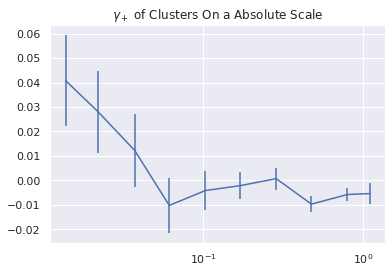

Aggregated xi:
[ -3.6338  -8.5769  -6.0367   9.888    7.8873   8.3238  -5.2435 124.1642
 135.1992  54.9349]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -380.5985 -1165.3706 -1621.5145 -2698.2133 -4326.4624 -6913.3902
 -9209.0992 -9551.4831 -5411.8208   953.735 ]
------------------------------------------------------------------------------
Aggregated npairs:
[   89.   306.   494.   968.  1906.  3907.  7361. 12811. 23485. 10212.]
------------------------------------------------------------------------------
Mean xi:
[-0.0408 -0.028  -0.0122  0.0102  0.0041  0.0021 -0.0007  0.0097  0.0058
  0.0054]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2764 -3.8084 -3.2824 -2.7874 -2.2699 -1.7695 -1.2511 -0.7456 -0.2304
  0.0934]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

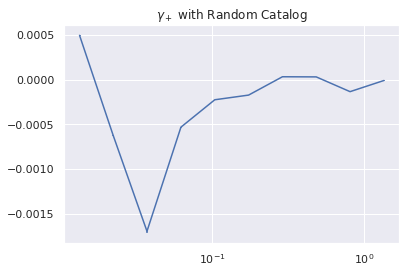

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

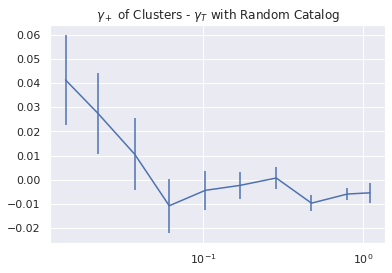

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

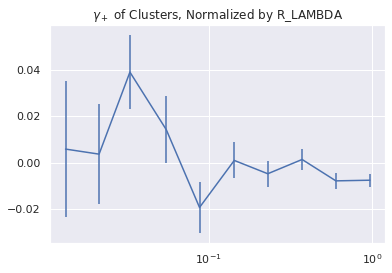

Aggregated xi:
[ -0.1758  -0.5667 -12.7497  -8.2547  19.6523  -2.0092  18.4823  -9.7567
  92.0041 154.8996]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -129.4749  -592.008  -1115.2249 -1684.3442 -2480.176  -4014.0266
 -5715.3518 -6972.5246 -6041.2564  -724.5628]
------------------------------------------------------------------------------
Aggregated npairs:
[   30.   154.   327.   581.  1020.  2066.  3883.  7051. 11759. 20535.]
------------------------------------------------------------------------------
Mean xi:
[-0.0059 -0.0037 -0.039  -0.0142  0.0193 -0.001   0.0048 -0.0014  0.0078
  0.0075]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3158 -3.8442 -3.4105 -2.899  -2.4315 -1.9429 -1.4719 -0.9889 -0.5138
 -0.0353]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)